# Neutrophil Signature Builder

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

# import deconvolution methods
import cellanneal
from scipy.optimize import nnls
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler


# statistical tests
import scipy.stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# stats & plot specific from .py files
from src.plot import Plot
from stats import statsTest
from src.helper import flatten, gene_intersection
import src.project_configs as project_configs
from src.deconv import Deconvolution

from tqdm import tqdm

To generate the data, change this to true

In [2]:
train_flag = False

#### GEO Database extractor

In [3]:
# import GEOparse

# gse = GEOparse.get_GEO(geo='GSE1688', destdir="./cell-deconvolution/data/GEO/")
# for name, gsm in gse.gsms.items():
#     name = name.strip("\n")
#     print("\t\t"+name+"transferred \n")
#     print(gse.gsms[name].table)
#     gse.gsms[name].table.to_csv("./cell-deconvolution/data/GEO/"+name+".txt", index=None, sep='\t', mode='w')

#### Converts ENSEMBL ID into Gene Names

In [4]:
df = pd.read_csv("../data/GEO/GSE166924_featurecounts_counts.txt.gz", sep = '\t', header=0)
df

,gene_id,10_E,10_M,10_N,10_S,11_E,11_M,11_N,11_S,12_E,...,6_N,7_E,7_M,7_N,8_E,8_M,8_N,9_E,9_M,9_N
0,ENSG00000000003,0,0,0,827,0,0,543,327,646,...,0,0,0,0,0,0,0,0,2,0
1,ENSG00000000005,0,0,0,14,0,0,0,57,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000000419,0,82,77,368,0,0,0,135,67,...,85,0,73,116,205,150,274,42,52,167
3,ENSG00000000457,0,0,82,71,0,0,0,15,53,...,60,0,6,7,0,42,92,0,28,79
4,ENSG00000000460,0,24,0,1,0,29,0,58,0,...,0,0,0,1,0,16,12,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58297,ENSG00000284744,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58298,ENSG00000284745,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58299,ENSG00000284746,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58300,ENSG00000284747,0,17,0,13,0,0,0,4,0,...,1,0,11,0,0,11,5,3,26,0


In [5]:
# with open('../data/GEO/Homo_sapiens.GRCh38.109.gtf') as f:
#     gtf = list(f)
    
    
# gtf = [x for x in gtf if not x.startswith('#')]
# gtf = [x for x in gtf if 'gene_id "' in x and 'gene_name "' in x]
# gtf = list(map(lambda x: (x.split('gene_id "')[1].split('"')[0], x.split('gene_name "')[1].split('"')[0]), gtf))
# gtf = list(set(gtf))
# gtf = dict(gtf)


In [6]:
# df['gene_id'] = df['gene_id'].map(gtf)
# df = df.dropna()
# df = df.set_index("gene_id")
# df = df[~df.index.duplicated(keep='first')]
# df

In [7]:
logfold = pd.read_csv("../data/differential_expression_results_sorted_MNPs_vs_neutrophs.csv.gz",compression="gzip")
logfold


,gene_id,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000163464,CXCR1,2714.440255,-10.611624,0.945826,-11.219430,3.273740e-29,8.575340e-26
1,ENSG00000163421,PROK2,724.768096,-10.546696,0.702408,-15.015052,5.851570e-51,1.072940e-46
2,ENSG00000230257,NFE4,131.946940,-10.294377,1.016819,-10.124098,4.319440e-24,8.800140e-21
3,ENSG00000140932,CMTM2,695.458442,-10.278832,0.728488,-14.109809,3.304710e-45,2.019840e-41
4,ENSG00000239839,DEFA3,91.052196,-10.144743,1.040649,-9.748474,1.872610e-22,2.641250e-19
...,...,...,...,...,...,...,...,...
18331,ENSG00000245869,AP004609.1,12.446961,7.120187,1.444368,4.929620,8.238950e-07,5.766010e-05
18332,ENSG00000205755,CRLF2,22.341429,7.221118,0.937050,7.706226,1.295930e-14,7.920710e-12
18333,ENSG00000116031,CD207,67.010901,7.735337,1.199967,6.446293,1.146190e-10,3.136800e-08
18334,ENSG00000158488,CD1E,62.718918,8.720672,0.778834,11.197085,4.213710e-29,9.657820e-26


In [8]:
import numpy as np
logfold["pval_log"] = np.log10(logfold["pvalue"]) * (-1)

<AxesSubplot: xlabel='log2FoldChange', ylabel='pval_log'>

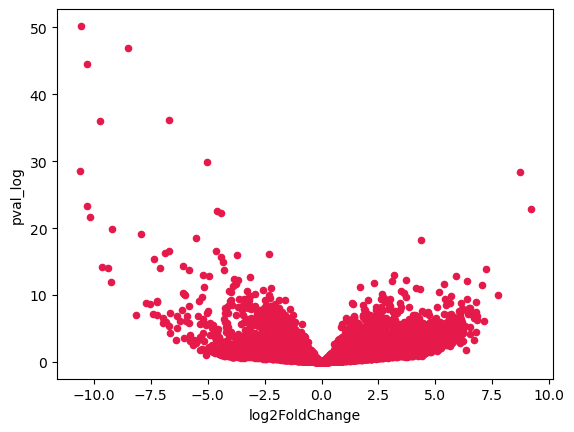

In [9]:
logfold.plot.scatter("log2FoldChange", y="pval_log")

In [10]:
multiply = dict(zip(logfold.gene_name, logfold.log2FoldChange))


In [11]:
multiply

{'CXCR1': -10.61162362,
 'PROK2': -10.54669564,
 'NFE4': -10.29437734,
 'CMTM2': -10.27883218,
 'DEFA3': -10.14474315,
 'FCGR3B': -9.716545924,
 'TGM3': -9.644084021,
 'NECAB2': -9.386147818,
 'AC073172.1': -9.245122996,
 'IL18RAP': -9.196204462,
 'CXCR2': -8.513978786,
 'KIR2DS4': -8.158333322,
 'PGLYRP1': -7.922061392,
 'CSF2RBP1': -7.695975102,
 'PRF1': -7.524324739,
 'LINC00211': -7.380486488,
 'LINC01506': -7.373179869,
 'ROPN1L': -7.213485072,
 'NLRP6': -7.200506872,
 'LINC00664': -7.198387159,
 'GPR27': -7.076298348,
 'GZMA': -6.968121485,
 'LINC02217': -6.950321104,
 'AC007342.3': -6.87098962,
 'MTNR1A': -6.830129531,
 'DRC1': -6.710116498,
 'CYP4F3': -6.697722622,
 'TNFRSF10C': -6.68515234,
 'SLC7A4': -6.667664422,
 'CSNK1A1L': -6.629840368,
 'KLK12': -6.389053519,
 'AC007278.1': -6.352485899,
 'AC020636.1': -6.324202845,
 'FOLR3': -6.19752305,
 'LINC00694': -6.125408855,
 'ALPL': -6.100196244,
 'VNN3': -6.07840598,
 'ADGRG3': -6.054666797,
 'DPP10': -6.024805364,
 'KCNJ15': -

In [12]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(multiply)
df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
df

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil
IGHV3-13,4.980656,1.333944,1.864680,1.532558,1.954512,1.864680
CEACAM7,4.380691,9.786583,3.619825,2.426693,3.630942,3.452990
HNF4A,3.485610,8.545540,2.476539,1.870433,2.601221,1.088885
IGLV10-54,6.287763,1.377721,2.887041,2.401113,3.306973,3.866068
RAB25,4.972021,9.833682,3.448122,2.608023,4.056638,1.592298
...,...,...,...,...,...,...
TRGC1,2.219735,1.275100,4.801744,0.742623,8.243333,4.801744
IFI30,8.746951,4.623365,9.757329,3.657667,4.645844,12.470294
VIL1,4.750310,9.462102,3.779563,2.664320,4.173139,1.864963
BMP5,2.511312,0.784588,2.129530,7.798015,1.550607,2.129530


In [13]:
df[df < 0] = 0

In [14]:
df.describe()

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,5.517996,3.962247,5.194770,4.321342,4.649688,5.096660
std,3.095362,3.503848,3.368753,2.976994,3.300556,3.890314
min,0.214358,0.044395,0.000000,0.118748,0.090971,0.000000
25%,3.188764,1.036454,2.315367,1.701242,1.958902,1.920527
50%,4.824465,2.615026,4.323460,3.657667,3.706480,4.067640
75%,7.329091,6.397613,7.899244,6.526265,6.834447,8.039119
max,15.844697,13.418437,13.527044,12.458132,13.125164,16.492995


In [15]:
df.to_csv('../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/Neutrophil-compartment.csv')

# Neutrophil Deconvolution

In [16]:
signature = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/Neutrophil-compartment.csv", index_col=0)
atap_bulk = pd.read_csv('../data/atap.pseudobulk_counts.logcpm.csv',index_col=0)
atap_true = pd.read_csv('../data/atap.scg_proportions.csv',index_col=0) 
cleveland_bulk = pd.read_csv('../data/cleveland.pseudobulk_counts.logcpm.csv',index_col=0)
cleveland_true = pd.read_csv('../data/cleveland.scg_proportions.csv',index_col=0)
lmu_bulk = pd.read_csv('../data/lmu.pseudobulk_counts.logcpm.csv',index_col=0)
lmu_true = pd.read_csv('../data/lmu.scg_proportions.csv',index_col=0)

In [17]:
signature

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil
IGHV3-13,4.980656,1.333944,1.864680,1.532558,1.954512,1.864680
CEACAM7,4.380691,9.786583,3.619825,2.426693,3.630942,3.452990
HNF4A,3.485610,8.545540,2.476539,1.870433,2.601221,1.088885
IGLV10-54,6.287763,1.377721,2.887041,2.401113,3.306973,3.866068
RAB25,4.972021,9.833682,3.448122,2.608023,4.056638,1.592298
...,...,...,...,...,...,...
TRGC1,2.219735,1.275100,4.801744,0.742623,8.243333,4.801744
IFI30,8.746951,4.623365,9.757329,3.657667,4.645844,12.470294
VIL1,4.750310,9.462102,3.779563,2.664320,4.173139,1.864963
BMP5,2.511312,0.784588,2.129530,7.798015,1.550607,2.129530


In [18]:
atap_bulk

,CID003352-2,CID003353-1,CID003354-1,CID003355-1,CID003356-1,CID003357-1,CID003358-1,CID003359-1,CID003360-1,CID003361-1,...,CID006575-1,CID006576-1,CID006577-1,CID006578-1,CID006579-1,CID006580-1,CID006581-1,CID006582-1,CID006583-1,CID006584-1
AL627309.1,4.559823,4.180552,4.676450,4.679879,4.824243,4.802711,1.286298,4.318929,3.932601,4.267790,...,4.147380,4.524373,4.643307,4.441311,4.223284,4.256402,3.997242,4.072200,3.576778,4.254133
AL669831.5,5.692943,5.615299,5.740056,5.776819,5.789183,5.722959,5.908257,5.471771,5.730656,5.691634,...,5.791949,5.711933,5.505242,5.898361,5.785888,6.145300,5.890507,5.712021,5.698469,5.699076
FAM87B,3.902404,3.435506,2.507945,2.666448,3.934694,3.367276,0.000000,3.725644,0.000000,2.456779,...,2.973753,3.137178,0.000000,3.463808,3.385178,2.235210,2.966472,3.204515,2.981255,2.887509
LINC00115,5.668646,5.737792,5.649675,5.744349,5.648648,5.680545,5.525414,5.778775,5.517505,5.631974,...,5.626930,5.565406,5.661558,5.500437,5.568606,5.753006,5.765951,5.588979,5.670604,5.412287
FAM41C,5.191993,4.940973,4.307157,5.389702,4.973539,5.240569,4.796521,4.719678,4.917628,5.090041,...,4.921058,5.173455,5.344289,5.380902,5.260708,5.206883,5.276639,4.998336,4.924234,4.721804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,5.665203,5.710806,5.580393,5.744432,5.710124,5.595571,5.902670,5.495567,4.788907,4.770870,...,5.295368,5.096542,5.361607,5.480183,5.159634,5.196747,5.423859,5.331434,5.380275,5.466377
AC004556.1,5.876481,6.140404,6.045300,5.825841,5.869335,5.900047,6.319135,5.901657,0.000000,1.616950,...,0.000000,1.699989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.051599,0.000000
AC233755.2,5.313590,4.410494,4.055638,4.132391,5.556562,4.592163,5.362222,4.703375,5.277674,5.604278,...,5.111750,4.842379,5.544127,5.349969,4.972502,3.649522,5.727452,5.563910,5.728996,5.269129
AC233755.1,5.392085,5.017379,5.237548,4.409528,5.518710,5.129587,4.111885,5.247575,5.734889,5.686145,...,5.460858,5.706396,3.981299,4.612089,4.848929,5.299855,5.694189,5.611382,5.412704,4.787839


In [19]:
atap_true_general =pd.DataFrame()          
atap_true_general['Myeloid'] = atap_true['CD209+ moDC'] + atap_true['CD83+ CLEC9A+ DC'] + atap_true['CD83- CLEC9A+ DC']+atap_true['CLEC10A+ DC']+atap_true['IL7R+ Activated DC']+atap_true['LTB+ DC']+atap_true['Mast Cell']+atap_true['Monocyte Inflammatory']+atap_true['Proliferating myeloid']+atap_true['Resident Macrophage']
atap_true_general['T Cell'] = atap_true['CD4 SELL naive'] + atap_true['CD4 TRM'] + atap_true['CD4 Tfh']+atap_true['CD4 Th17']+atap_true['CD4 Tfr'] + atap_true['CD4 Th1']+atap_true['CD4 Tph']+atap_true['CD4 Treg']+atap_true['CD8 Effector']+atap_true['CD8 IEL']+atap_true['CD8 SELL Naive']+atap_true['ILC3']+atap_true['MAIT']+atap_true['NK']+atap_true['Proliferating T cells']+atap_true['gd T cell 1']+atap_true['gd T cell 2']
atap_true_general['B Cell'] = atap_true['GC-like B cell'] + atap_true['Memory B cell'] + atap_true['Naive B cell']+atap_true['Plasma Cell']+atap_true['Plasmablast']
atap_true_general['Stroma'] = atap_true['Arterial Pericyte'] + atap_true['Blood Endothelial Cell'] + atap_true['Fibroblast']+atap_true['Glial Cell']+atap_true['Inflammatory Fibroblast']+atap_true['Lymphatic Endothelial Cell']+atap_true['Myofibroblast']+atap_true['Pericyte']+atap_true['Post-capillary venules']+atap_true['Proliferating Stromal Cell']+atap_true['Smooth Muscle Cell']
atap_true_general['Epithelium'] = atap_true['Enterocyte'] + atap_true['Enteroendocrine Cell'] + atap_true['Epithelial M Cell']+atap_true['Epithelial Progenitor Cell']+atap_true['Epithelial Stem Cell']+atap_true['Goblet Cell']+atap_true['Tuft Cell']

In [20]:
deconvolution_object = Deconvolution()
plot_object = Plot()

In [21]:
signature

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil
IGHV3-13,4.980656,1.333944,1.864680,1.532558,1.954512,1.864680
CEACAM7,4.380691,9.786583,3.619825,2.426693,3.630942,3.452990
HNF4A,3.485610,8.545540,2.476539,1.870433,2.601221,1.088885
IGLV10-54,6.287763,1.377721,2.887041,2.401113,3.306973,3.866068
RAB25,4.972021,9.833682,3.448122,2.608023,4.056638,1.592298
...,...,...,...,...,...,...
TRGC1,2.219735,1.275100,4.801744,0.742623,8.243333,4.801744
IFI30,8.746951,4.623365,9.757329,3.657667,4.645844,12.470294
VIL1,4.750310,9.462102,3.779563,2.664320,4.173139,1.864963
BMP5,2.511312,0.784588,2.129530,7.798015,1.550607,2.129530


In [22]:
if train_flag:
    models = deconvolution_object.train(signature, atap_bulk)
    models[0].to_csv("../data/results5/cellanneal_atap_logcpm.csv")
    models[1].to_csv("../data/results5/svr_atap_logcpm.csv")
    models = deconvolution_object.train(signature, cleveland_bulk)
    models[0].to_csv("../data/results5/cellanneal_cleveland_logcpm.csv")
    models[1].to_csv("../data/results5/svr_cleveland_logcpm.csv")
    models = deconvolution_object.train(signature, lmu_bulk)
    models[0].to_csv("../data/results5/cellanneal_lmu_logcpm.csv")
    models[1].to_csv("../data/results5/svr_lmu_logcpm.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results5/cellanneal_atap_logcpm.csv",index_col=0)
    svr_atap = pd.read_csv("../data/results5/svr_atap_logcpm.csv",index_col=0)
    cellanneal_cleveland = pd.read_csv("../data/results5/cellanneal_cleveland_logcpm.csv",index_col=0)
    svr_cleveland =  pd.read_csv("../data/results5/svr_cleveland_logcpm.csv",index_col=0)
    cellanneal_lmu =  pd.read_csv("../data/results5/cellanneal_lmu_logcpm.csv",index_col=0)
    svr_lmu = pd.read_csv("../data/results5/svr_lmu_logcpm.csv",index_col=0)

In [23]:
cellanneal_atap

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil,rho_Spearman,rho_Pearson
CID003352-2,0.081203,0.091970,0.082324,0.564852,0.179206,0.000444,0.856147,0.743439
CID003353-1,0.015262,0.622589,0.001280,0.169564,0.190870,0.000435,0.922358,0.825426
CID003354-1,0.008921,0.465399,0.000714,0.406772,0.117317,0.000878,0.894832,0.790704
CID003355-1,0.365637,0.210208,0.012371,0.136187,0.274424,0.001173,0.825479,0.641656
CID003356-1,0.022838,0.218988,0.006639,0.420755,0.325375,0.005406,0.892215,0.776613
...,...,...,...,...,...,...,...,...
CID006580-1,0.240171,0.000472,0.140442,0.280040,0.291275,0.047601,0.806153,0.651973
CID006581-1,0.047112,0.002558,0.145586,0.469638,0.323892,0.011214,0.782119,0.667728
CID006582-1,0.224523,0.166544,0.000475,0.436560,0.171147,0.000750,0.824252,0.667998
CID006583-1,0.084156,0.011615,0.007298,0.544814,0.347822,0.004296,0.860865,0.727255


In [24]:
# plot parameters all coming from project.configurations
plt.style.use(project_configs.style)
plt.rcParams['font.family'] = project_configs.font_family
plt.rcParams['font.serif'] = project_configs.font_serif
plt.rcParams['font.monospace'] = project_configs.font_monospace
plt.rcParams['font.size'] = project_configs.font_size
plt.rcParams['axes.labelsize'] = project_configs.axes_label_size
plt.rcParams['axes.labelweight'] = project_configs.axes_label_weight
plt.rcParams['axes.titlesize'] = project_configs.axes_title_size
plt.rcParams['xtick.labelsize'] = project_configs.xtick_label_size
plt.rcParams['ytick.labelsize'] = project_configs.ytick_label_size
plt.rcParams['legend.fontsize'] = project_configs.legend_font_size 
plt.rcParams['figure.titlesize'] = project_configs.figure_title_size
plt.rcParams['image.cmap'] = project_configs.image_cmap 
plt.rcParams['image.interpolation'] = project_configs.image_interpolation 
plt.rcParams['figure.figsize'] = project_configs.figure_size
plt.rcParams['axes.grid']=project_configs.axes_grid
plt.rcParams['lines.linewidth'] = project_configs.lines_line_width
plt.rcParams['lines.markersize'] = project_configs.lines_marker_size
cells_p = project_configs.cells_p

(0.0, 1.0)

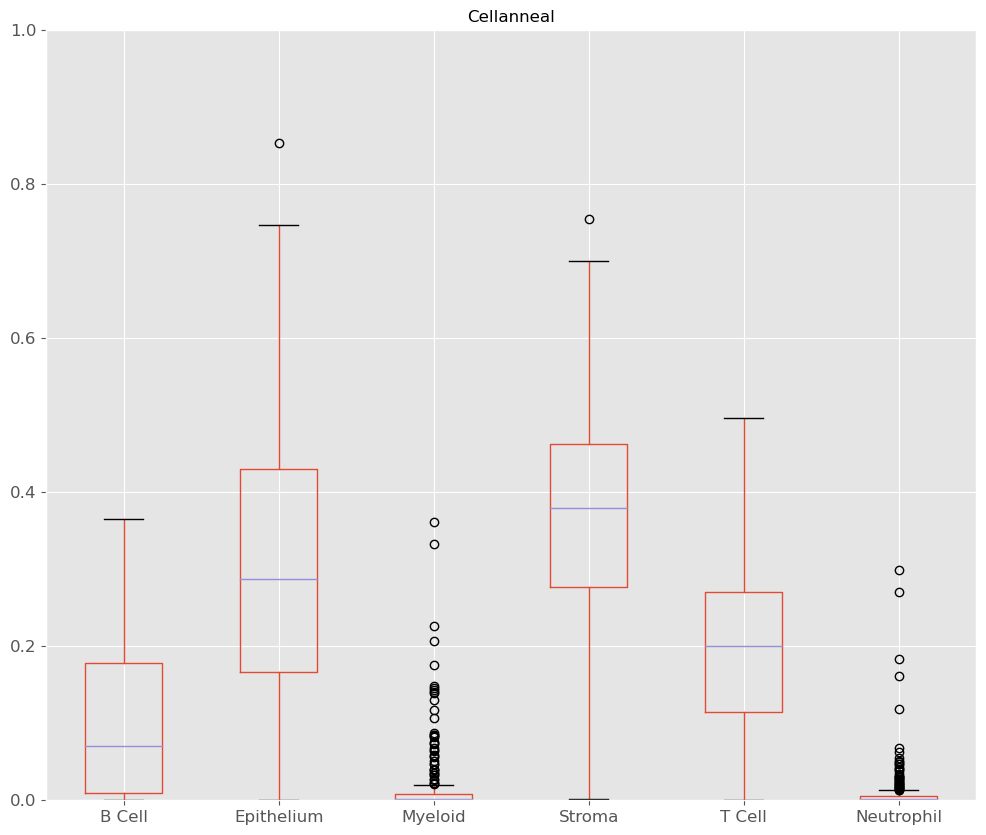

In [25]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])


(0.0, 1.0)

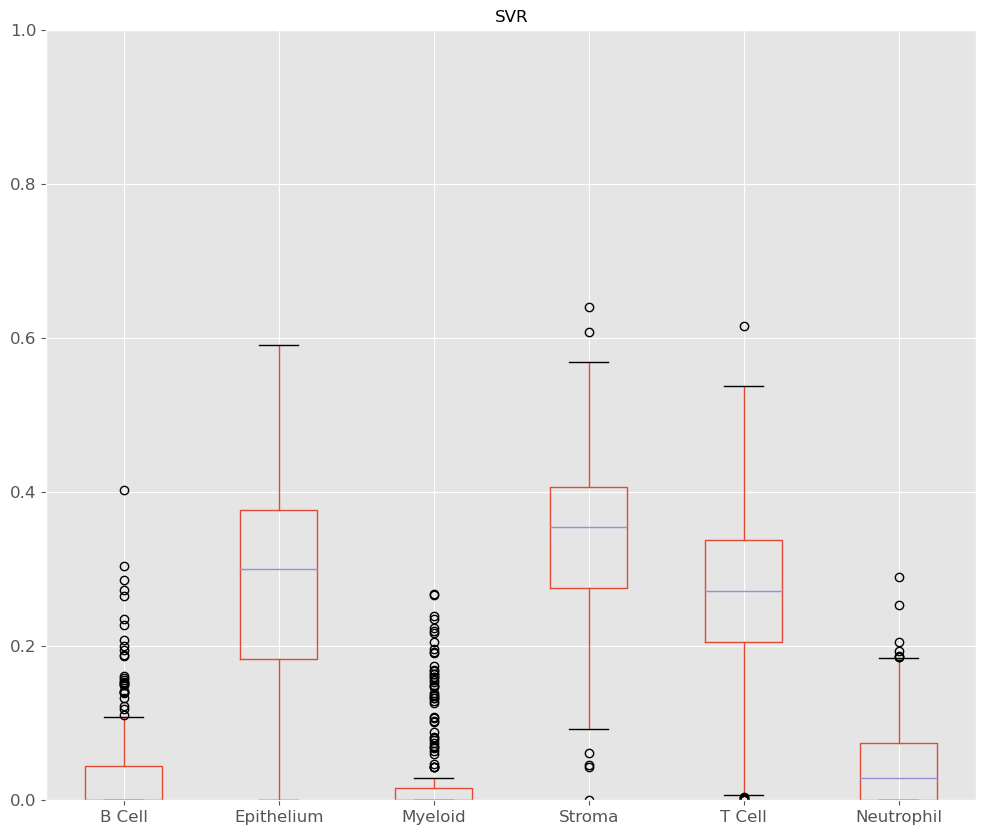

In [26]:
svr_atap.T.boxplot()
plt.title("SVR")
plt.ylim([0,1.0])


(0.0, 1.0)

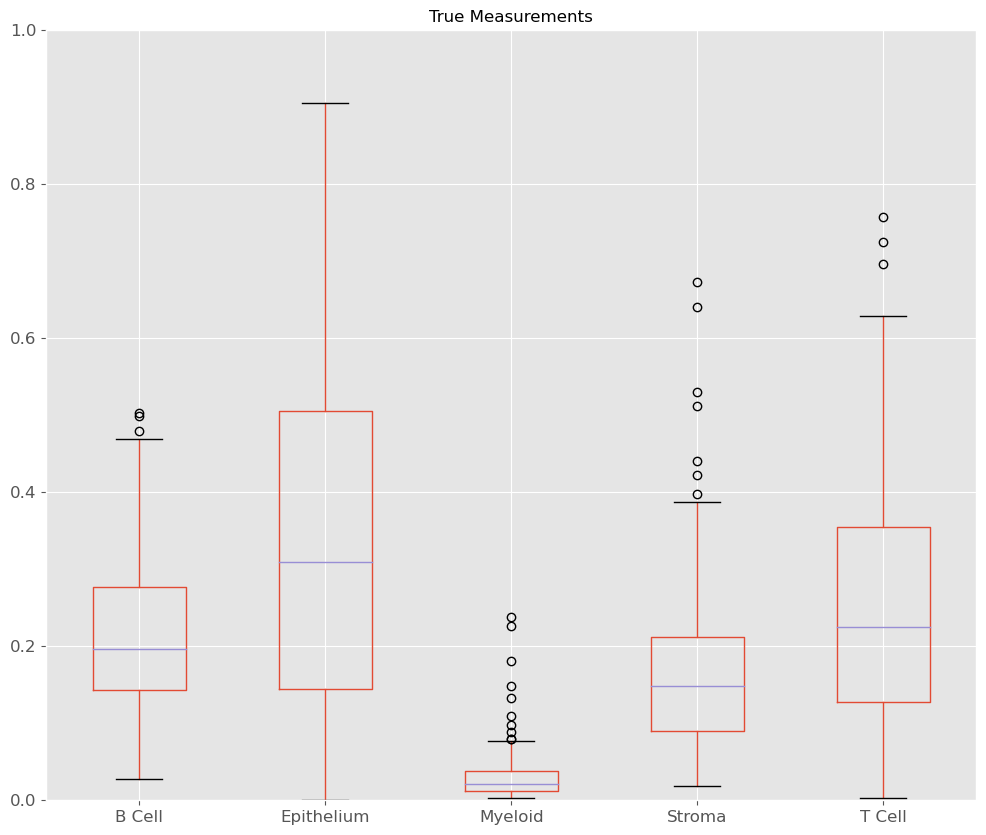

In [27]:
atap_true_general.reindex(sorted(atap_true_general.columns), axis=1).boxplot()
plt.title("True Measurements")
plt.ylim([0,1.0])


# Less Markers

In [28]:
logfold = pd.read_excel("../data/neu-mnp.xlsx",index_col=0)
logfold

,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,,
ENSG00000102962,CCL22,417.080544,9.178012,0.917534,10.002907,1.479880e-23,2.713509e-20
ENSG00000158488,CD1E,62.718918,8.720672,0.778834,11.197085,4.213708e-29,9.657818e-26
ENSG00000116031,CD207,67.010901,7.735337,1.199967,6.446293,1.146191e-10,3.136800e-08
ENSG00000205755,CRLF2,22.341429,7.221118,0.937050,7.706226,1.295928e-14,7.920711e-12
ENSG00000245869,AP004609.1,12.446961,7.120187,1.444368,4.929620,8.238951e-07,5.766008e-05
...,...,...,...,...,...,...,...
ENSG00000239839,DEFA3,91.052196,-10.144743,1.040649,-9.748474,1.872613e-22,2.641248e-19
ENSG00000140932,CMTM2,695.458442,-10.278832,0.728488,-14.109809,3.304713e-45,2.019841e-41
ENSG00000230257,NFE4,131.946940,-10.294377,1.016819,-10.124098,4.319441e-24,8.800142e-21


In [29]:
multiply2 = dict(zip(logfold.gene_name, logfold.log2FoldChange))

In [30]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(multiply2)
df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
df

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil
IGHV3-13,4.980656,1.333944,1.864680,1.532558,1.954512,1.864680
CEACAM7,4.380691,9.786583,3.619825,2.426693,3.630942,3.619825
HNF4A,3.485610,8.545540,2.476539,1.870433,2.601221,2.476539
IGLV10-54,6.287763,1.377721,2.887041,2.401113,3.306973,2.887041
RAB25,4.972021,9.833682,3.448122,2.608023,4.056638,3.448122
...,...,...,...,...,...,...
TRGC1,2.219735,1.275100,4.801744,0.742623,8.243333,4.801744
IFI30,8.746951,4.623365,9.757329,3.657667,4.645844,12.470294
VIL1,4.750310,9.462102,3.779563,2.664320,4.173139,3.779563
BMP5,2.511312,0.784588,2.129530,7.798015,1.550607,2.129530


In [31]:
signature = df

In [32]:
if train_flag:
    models = deconvolution_object.train(signature, atap_bulk)
    models[0].to_csv("../data/results5/cellanneal_atap_logcpm2.csv")
    models[1].to_csv("../data/results5/svr_atap_logcpm2.csv")

else:
    cellanneal_atap = pd.read_csv("../data/results5/cellanneal_atap_logcpm2.csv",index_col=0)
    svr_atap = pd.read_csv("../data/results5/svr_atap_logcpm2.csv",index_col=0)


(0.0, 1.0)

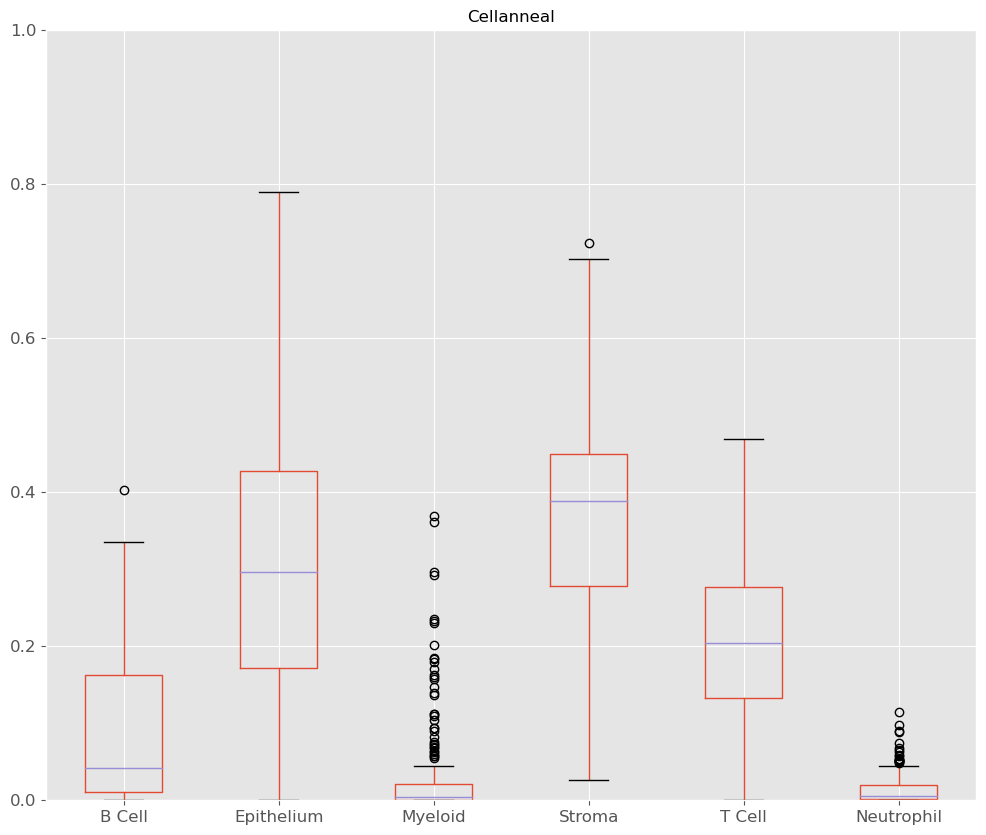

In [33]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

In [34]:
svr_atap

,CID003352-2,CID003353-1,CID003354-1,CID003355-1,CID003356-1,CID003357-1,CID003358-1,CID003359-1,CID003360-1,CID003361-1,...,CID006575-1,CID006576-1,CID006577-1,CID006578-1,CID006579-1,CID006580-1,CID006581-1,CID006582-1,CID006583-1,CID006584-1
B Cell,0.000000,0.000000,0.086271,0.000000,0.042902,0.045431,0.000000,0.000000,0.021567,0.038501,...,0.000000,0.004725,0.177246,0.061928,0.000000,0.000000,0.168492,0.176338,0.000000,0.000000
Epithelium,0.121949,0.547085,0.382465,0.321405,0.201403,0.237867,0.340889,0.298534,0.132381,0.273572,...,0.201478,0.223889,0.000000,0.000000,0.047500,0.000000,0.000000,0.135814,0.000000,0.163663
Myeloid,0.083960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.058103,0.000000,0.112444,0.077241,0.000000,0.000000,0.025228
Stroma,0.569907,0.118756,0.263783,0.030624,0.360648,0.242042,0.308201,0.318126,0.417211,0.353647,...,0.314569,0.292430,0.452810,0.540512,0.491888,0.347600,0.308431,0.365868,0.449830,0.464712
T Cell,0.224185,0.305096,0.201819,0.496388,0.395047,0.302321,0.258913,0.287076,0.336853,0.280513,...,0.376804,0.394888,0.331646,0.339457,0.295385,0.389201,0.445835,0.321981,0.492298,0.346397
Neutrophil,0.000000,0.029064,0.065662,0.151583,0.000000,0.172340,0.091997,0.096264,0.091988,0.053768,...,0.107150,0.084069,0.038298,0.000000,0.165228,0.150754,0.000000,0.000000,0.057872,0.000000


(0.0, 1.0)

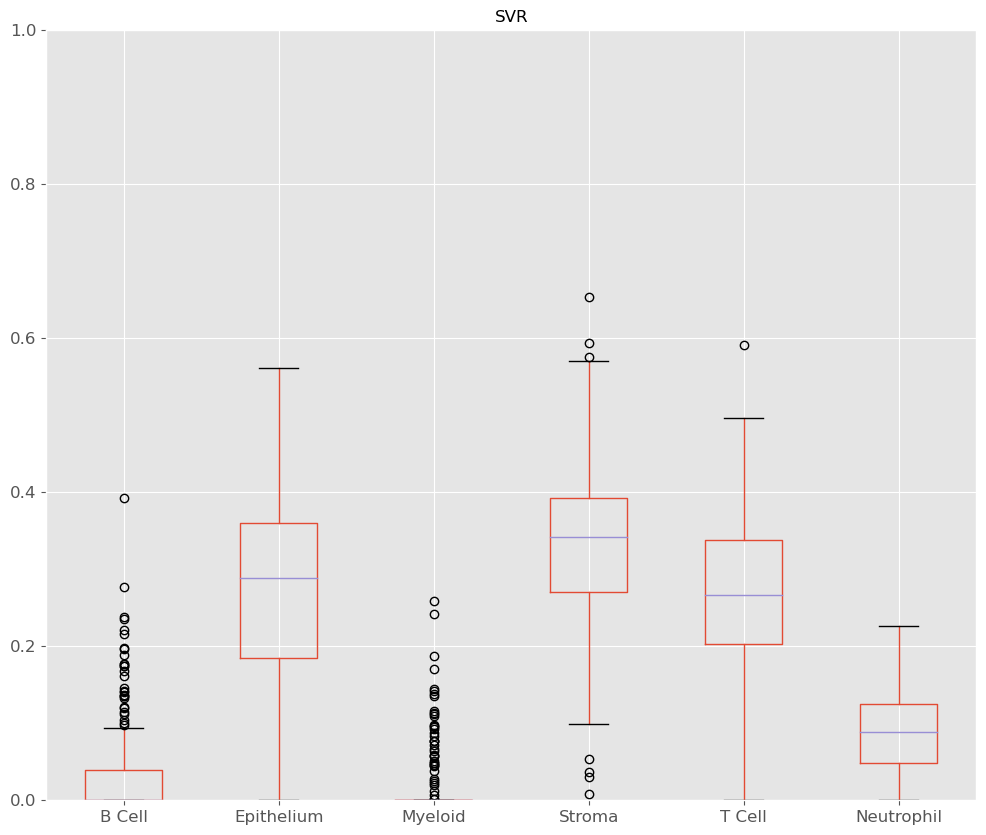

In [35]:
temp = svr_atap.T
temp.boxplot()
plt.title("SVR")
plt.ylim([0,1.0])

# reduce gene markers

In [36]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(multiply2)
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
signature = df

82


In [37]:
df

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil
IGHV3-13,4.980656,1.333944,1.864680,1.532558,1.954512,1.864680
CEACAM7,4.380691,9.786583,3.619825,2.426693,3.630942,3.619825
HNF4A,3.485610,8.545540,2.476539,1.870433,2.601221,2.476539
IGLV10-54,6.287763,1.377721,2.887041,2.401113,3.306973,2.887041
RAB25,4.972021,9.833682,3.448122,2.608023,4.056638,3.448122
...,...,...,...,...,...,...
TRGC1,2.219735,1.275100,4.801744,0.742623,8.243333,4.801744
IFI30,8.746951,4.623365,9.757329,3.657667,4.645844,12.470294
VIL1,4.750310,9.462102,3.779563,2.664320,4.173139,3.779563
BMP5,2.511312,0.784588,2.129530,7.798015,1.550607,2.129530


In [38]:
temp = df.iloc[:,-1]
temp=temp[temp!=0]
temp = temp.sort_values()
temp

KLK12       -5.569969
ALPL        -4.838718
ITLN2       -4.682456
LTF         -3.564156
KLRD1       -2.664482
              ...    
HLA-DPB1    15.447853
HLA-DRA     15.657335
CCL22       16.329279
FCER1A      16.333125
CD1E        16.492995
Name: Neutrophil, Length: 502, dtype: float64

In [39]:
multiply = dict(zip(temp.index, temp.values))

# takes top N genes

(0.0, 1.0)

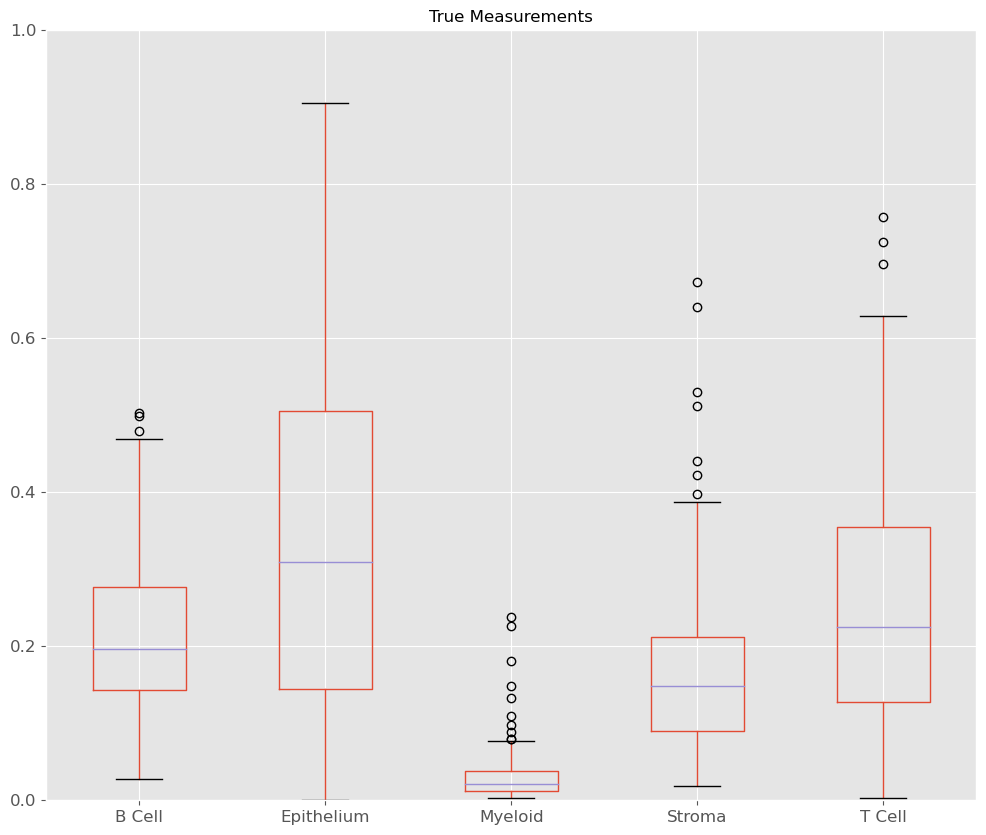

In [40]:
atap_true_general.reindex(sorted(atap_true_general.columns), axis=1).boxplot()
plt.title("True Measurements")
plt.ylim([0,1.0])

# finding the best values

# 60 genes

In [41]:
log = {A:N for (A,N) in [x for x in multiply.items()][:60]}

In [42]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
signature = df

60


In [43]:
if train_flag:
    models = deconvolution_object.deconvolution(signature, atap_bulk)
    models.to_csv("../data/results5/cellanneal_neutrophil_top60.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results5/cellanneal_neutrophil_top60.csv",index_col=0)

(0.0, 1.0)

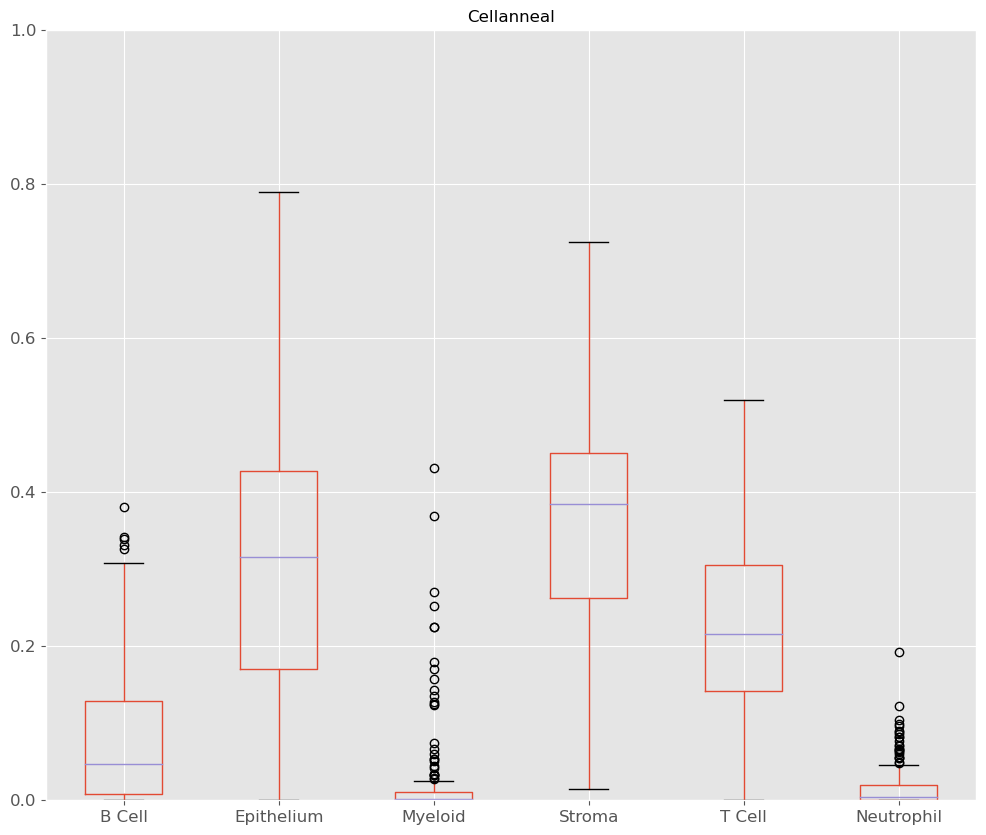

In [44]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

# 40 genes

In [45]:
log = {A:N for (A,N) in [x for x in multiply.items()][:40]}

In [46]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
signature = df

40


In [47]:
if train_flag:
    models = deconvolution_object.deconvolution(signature, atap_bulk)
    models.to_csv("../data/results5/cellanneal_neutrophil_top40.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results5/cellanneal_neutrophil_top40.csv",index_col=0)

(0.0, 1.0)

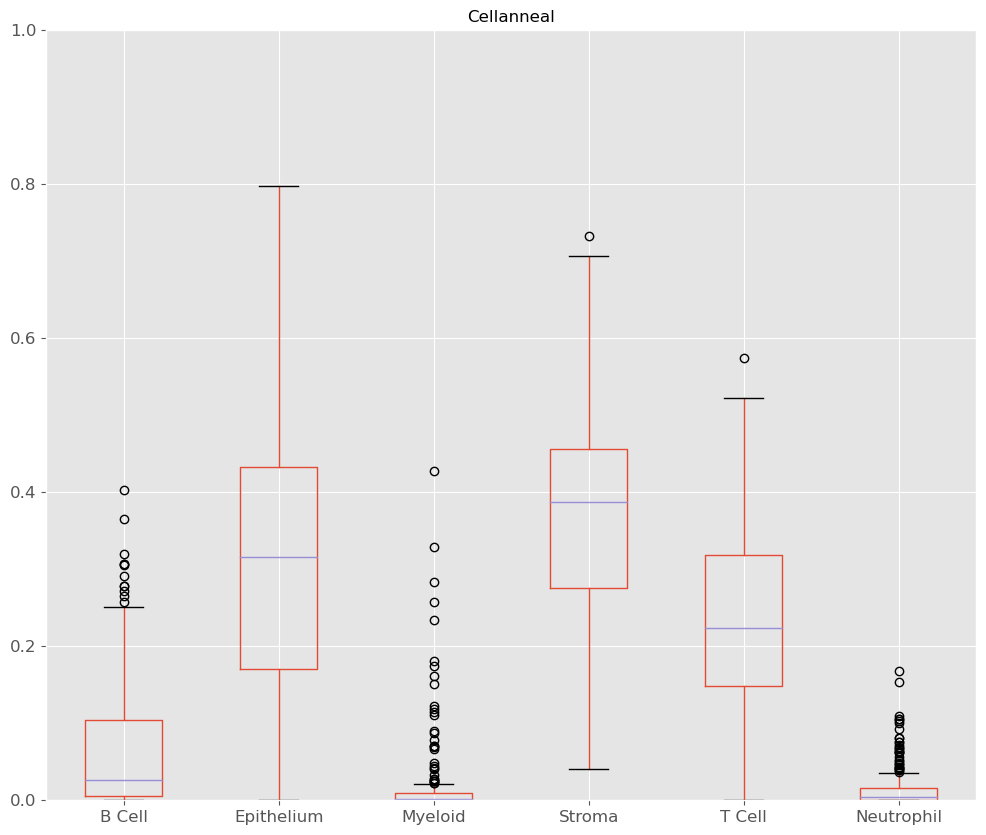

In [48]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

# 20 genes

In [49]:
log = {A:N for (A,N) in [x for x in multiply.items()][:20]}

In [50]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
signature = df

20


In [51]:
if train_flag:
    models = deconvolution_object.deconvolution(signature, atap_bulk)
    models.to_csv("../data/results5/cellanneal_neutrophil_top20.csv")


else:
    cellanneal_atap = pd.read_csv("../data/results5/cellanneal_neutrophil_top20.csv",index_col=0)

(0.0, 1.0)

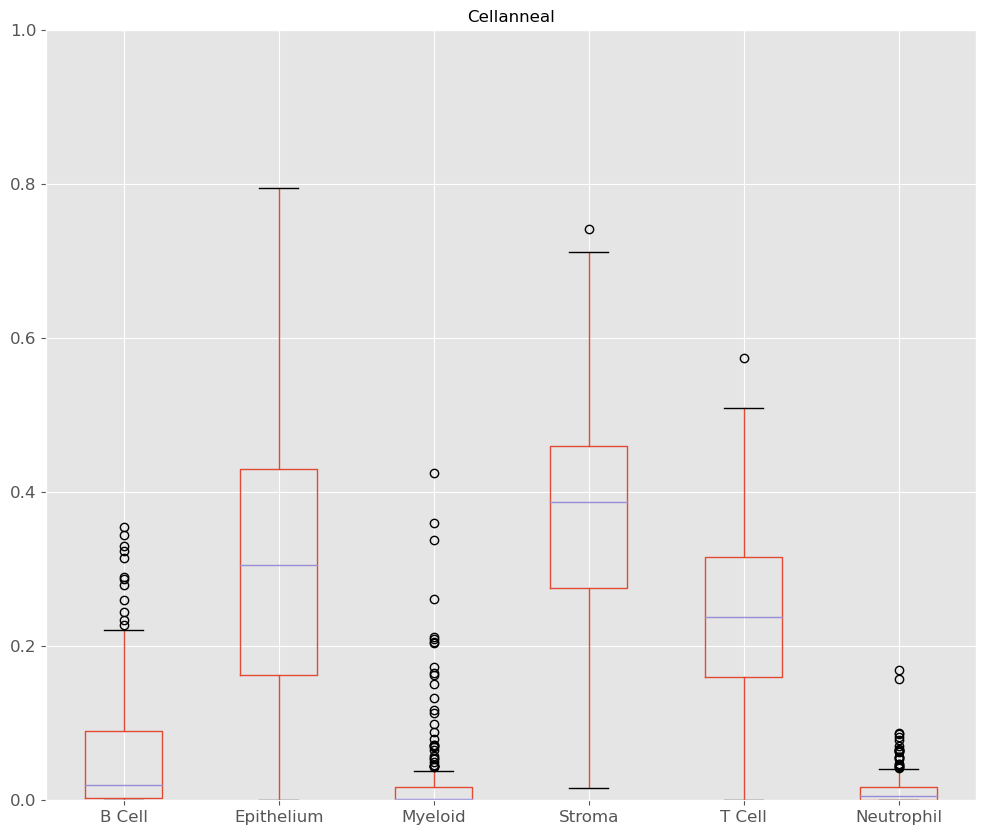

In [52]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

# 10 genes

In [53]:
log = {A:N for (A,N) in [x for x in multiply.items()][:10]}

In [54]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
signature = df

10


In [55]:
if train_flag:
    models = deconvolution_object.deconvolution(signature, atap_bulk)
    models.to_csv("../data/results5/cellanneal_neutrophil_top10.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results5/cellanneal_neutrophil_top10.csv",index_col=0)

(0.0, 1.0)

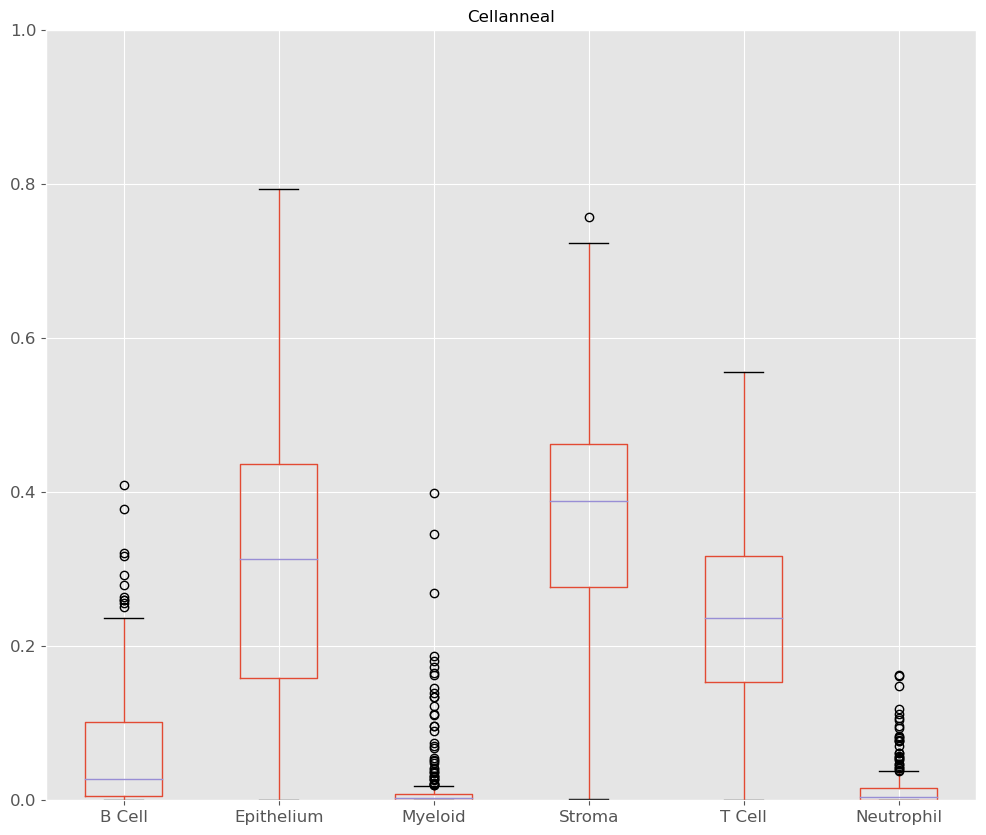

In [56]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

# 5 genes

In [57]:
log = {A:N for (A,N) in [x for x in multiply.items()][:5]}

In [58]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
signature = df

5


In [59]:
if train_flag:
    models = deconvolution_object.deconvolution(signature, atap_bulk)
    models.to_csv("../data/results5/cellanneal_neutrophil_top5.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results5/cellanneal_neutrophil_top5.csv",index_col=0)

(0.0, 1.0)

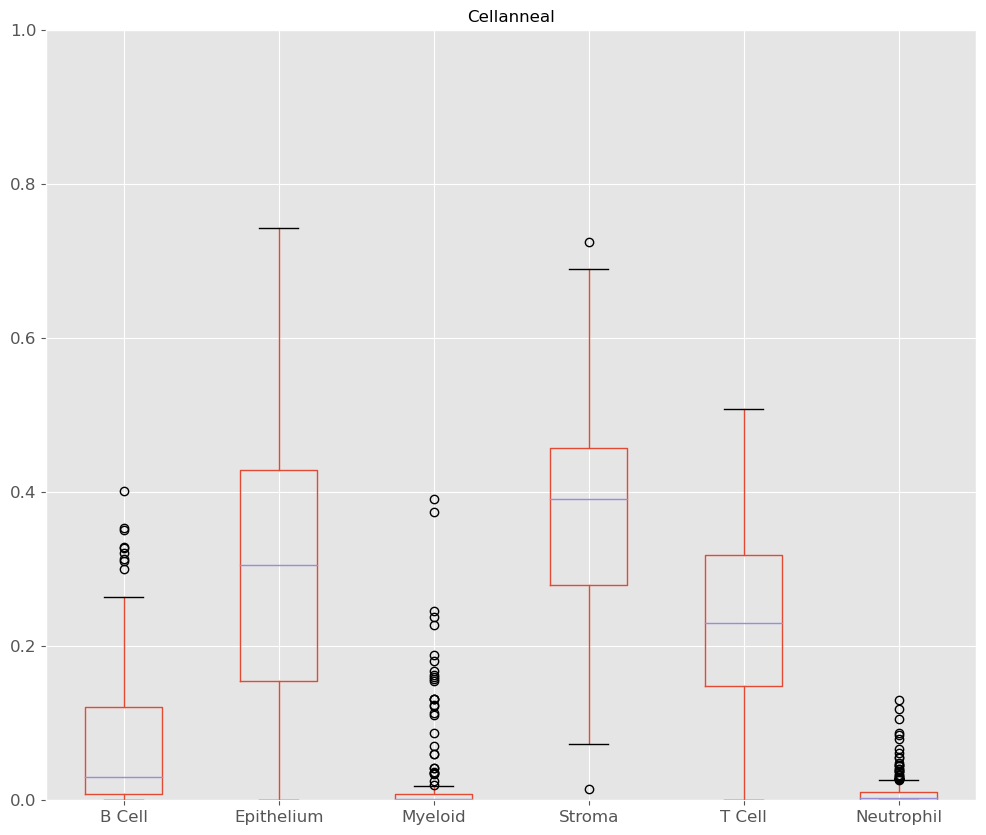

In [60]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

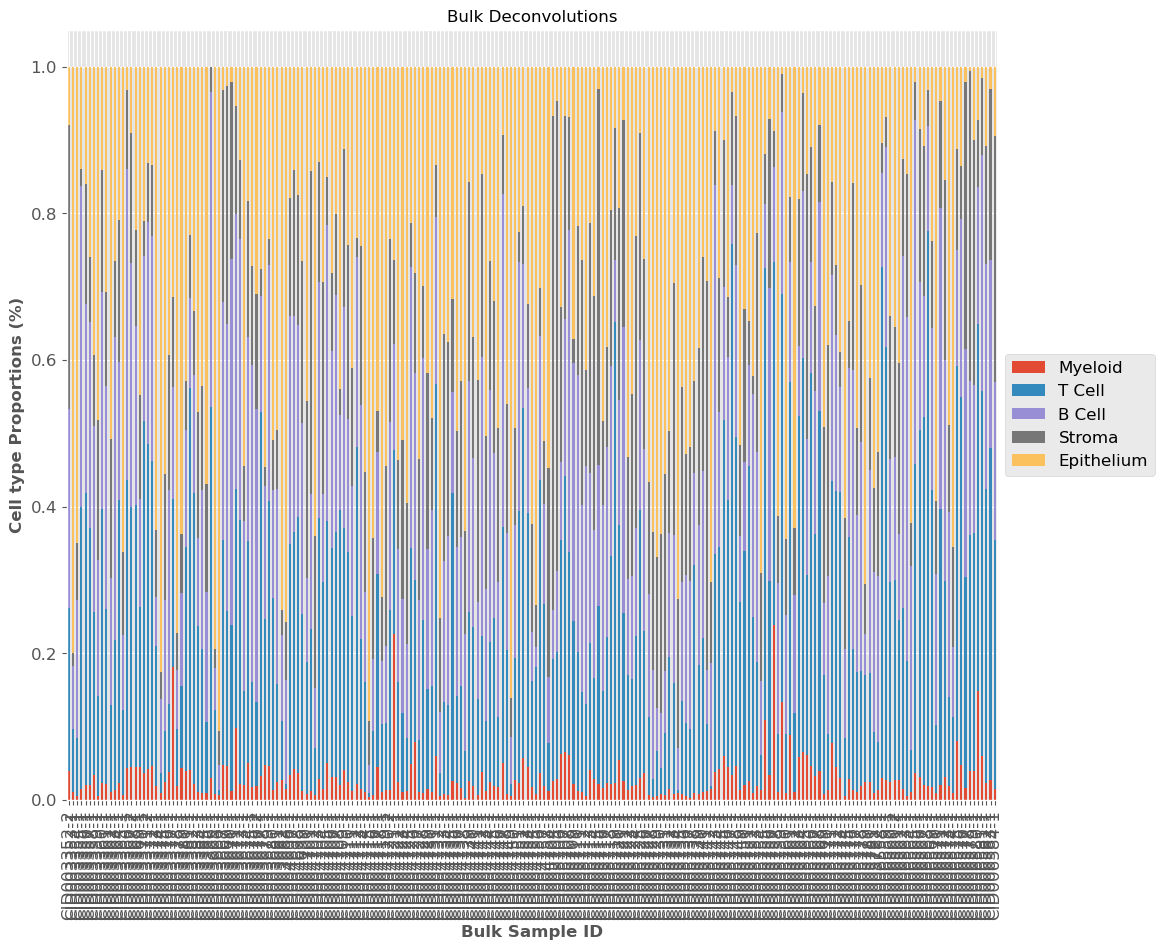

In [61]:
plot_object.stack_plot(atap_true_general)

# 1 gene

In [62]:
log = {A:N for (A,N) in [x for x in multiply.items()][:1]}

In [63]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
signature = df

1


In [64]:
if train_flag:
    models = deconvolution_object.deconvolution(signature, atap_bulk)
    models.to_csv("../data/results5/cellanneal_neutrophil_top1.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results5/cellanneal_neutrophil_top1.csv",index_col=0)

(0.0, 1.0)

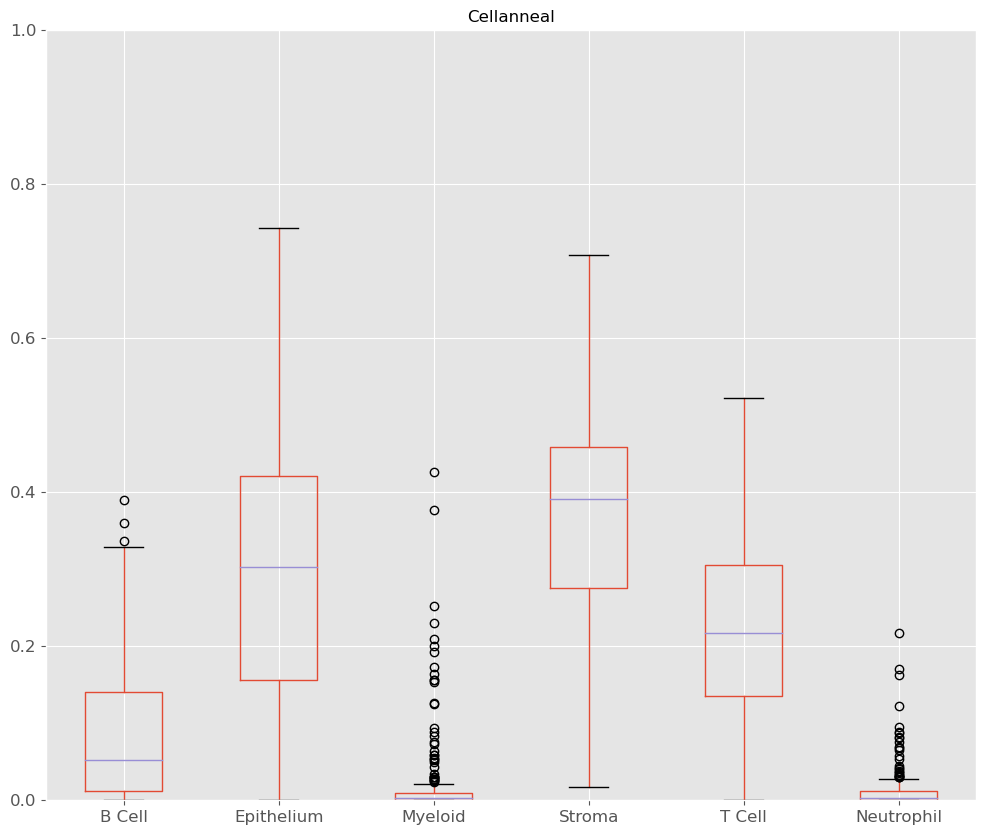

In [65]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

# Only keep neutrophil genes now. Zero out the rest

# all genes

In [66]:
cells_p = {'B Cell': '#558ce0',
            'T Cell': '#28a35c',
            'Myeloid': '#58d3bb',
            'Stroma': '#eaabcc',
            'Epithelium': '#F6783E',
}

In [67]:
log = {A:N for (A,N) in [x for x in multiply.items()][:80]}

In [68]:
log

{'KLK12': -5.569968698532718,
 'ALPL': -4.838717942361145,
 'ITLN2': -4.682455756981469,
 'LTF': -3.564156144119388,
 'KLRD1': -2.664481764723114,
 'GZMA': -2.071523408258189,
 'PCSK1N': -1.8992199174638573,
 'DDC': -1.6193924939830078,
 'CHGA': -1.02310895244942,
 'HEPACAM2': -0.961300749459808,
 'PRSS8': -0.045467908299362314,
 'TRDC': -0.031093352447803646,
 'SOHLH2': 0.0221602565294122,
 'SLPI': 0.03161245426447845,
 'IGKV5-2': 0.0656526905370294,
 'PMCH': 0.1544966532416736,
 'MEOX2': 0.175543317403987,
 'GJA5': 0.1801452705883998,
 'IGKV2-28': 0.2567912643322231,
 'FNDC1': 0.3047688219410484,
 'IL22RA1': 0.3485663334444661,
 'FEV': 0.4089473814332727,
 'IGKV1D-43': 0.4324305026443017,
 'CDH19': 0.4396922030924369,
 'MYOCD': 0.4495288977422345,
 'EFS': 0.5338010535951228,
 'IGLV5-37': 0.5457191768676704,
 'IL13RA2': 0.5950079852470382,
 'DHRS7C': 0.623045369727788,
 'IGLV9-49': 0.6922499783494223,
 'DKK1': 0.6948288099643493,
 'FAM13C': 0.7259209328818284,
 'PAEP': 0.7539114363205

In [69]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
df = df.drop("logfold",axis=1)
df[df < 0] = 0
signature = df


In [70]:
signature.T.KLK12

B Cell        2.017800
Epithelium    5.258521
Myeloid       0.819085
Stroma        0.377455
T Cell        0.644127
Neutrophil    0.000000
Name: KLK12, dtype: float64

In [71]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top80.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top80.csv",index_col=0)

(0.0, 1.0)

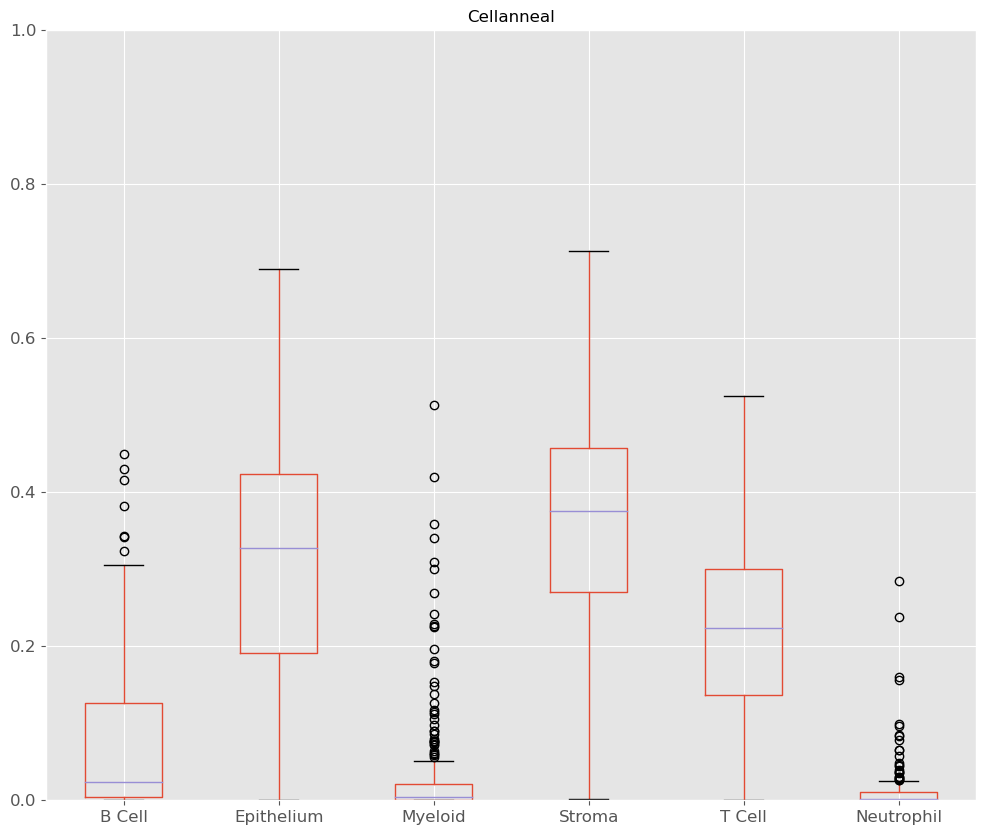

In [72]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.373\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.921\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.622\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.857\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.893\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

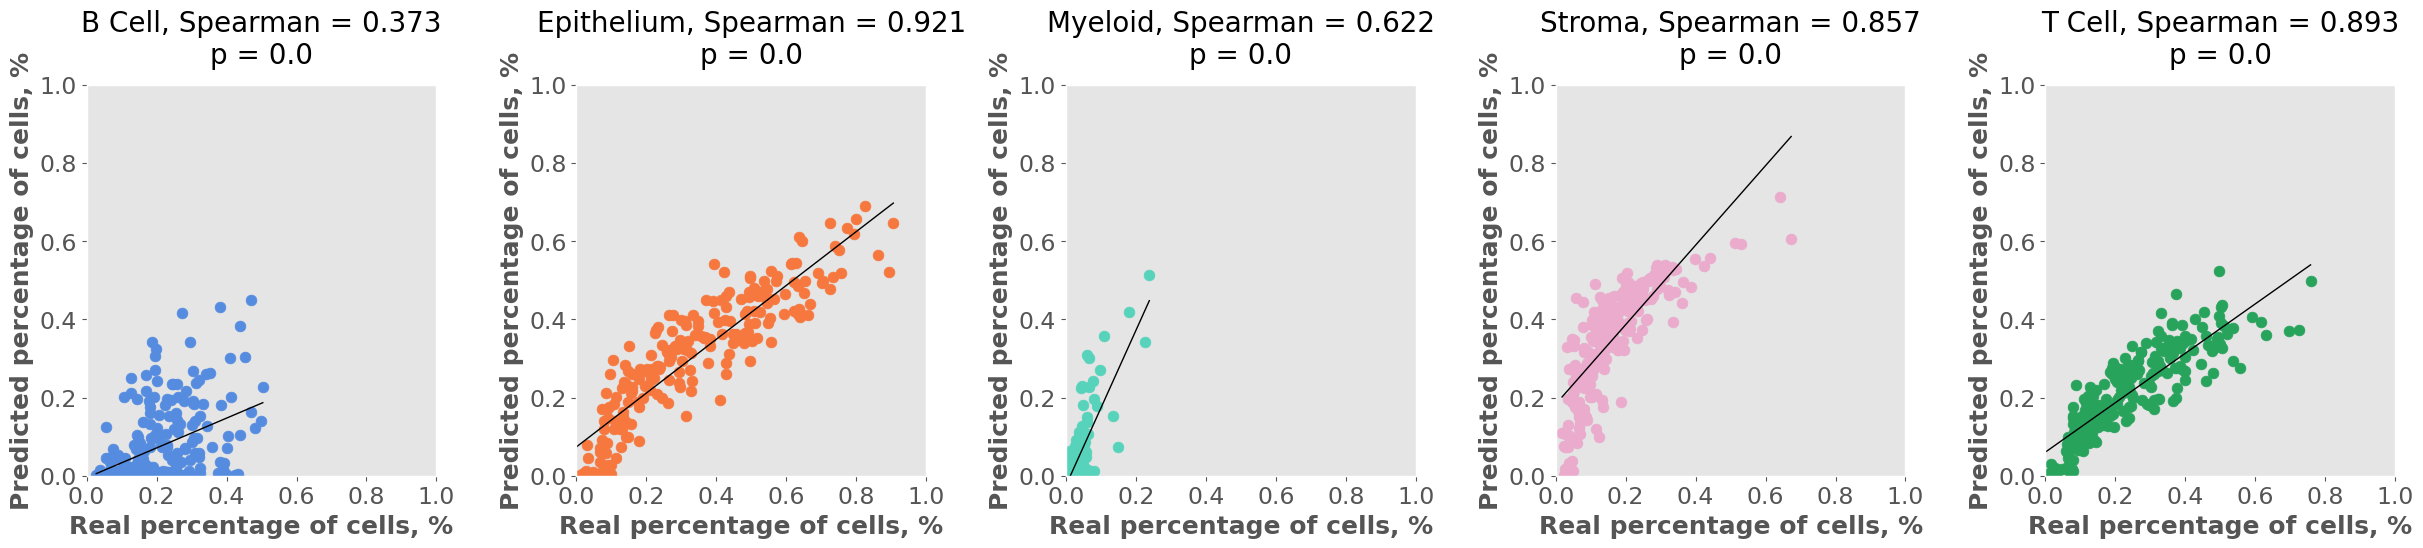

In [73]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

In [74]:
cellanneal_atap.describe()

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil,rho_Spearman,rho_Pearson
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.076985,0.306633,0.033311,0.351877,0.218602,0.012592,0.809673,0.699909
std,0.098380,0.168276,0.075391,0.135794,0.112255,0.032305,0.098936,0.132738
min,0.000008,0.000149,0.000018,0.001836,0.000088,0.000004,0.500259,0.328906
25%,0.004283,0.191227,0.000702,0.270213,0.136908,0.000599,0.728162,0.613062
50%,0.024102,0.327026,0.003650,0.375737,0.223553,0.002203,0.837517,0.719702
75%,0.126803,0.424149,0.021397,0.457962,0.300690,0.010802,0.895231,0.809692
max,0.449896,0.689563,0.513452,0.712940,0.524686,0.284916,0.943434,0.888497


# 60 genes

In [75]:
log = {A:N for (A,N) in [x for x in multiply.items()][:60]}

In [76]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

60


In [77]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top60.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top60.csv",index_col=0)

In [78]:
cellanneal_atap.describe()

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil,rho_Spearman,rho_Pearson
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.131613,0.310079,0.038477,0.284258,0.224514,0.011059,0.823676,0.702723
std,0.109214,0.185954,0.078430,0.150940,0.145458,0.021083,0.083810,0.130171
min,0.000013,0.000032,0.000039,0.000478,0.000029,0.000009,0.544962,0.309430
25%,0.038632,0.179194,0.002522,0.169207,0.110334,0.000627,0.779625,0.631580
50%,0.106833,0.320575,0.008338,0.312982,0.227869,0.003327,0.849142,0.734272
75%,0.197796,0.439182,0.030739,0.390641,0.320770,0.011753,0.886197,0.799309
max,0.448858,0.807390,0.486175,0.628581,0.607587,0.182242,0.936912,0.900820


(0.0, 1.0)

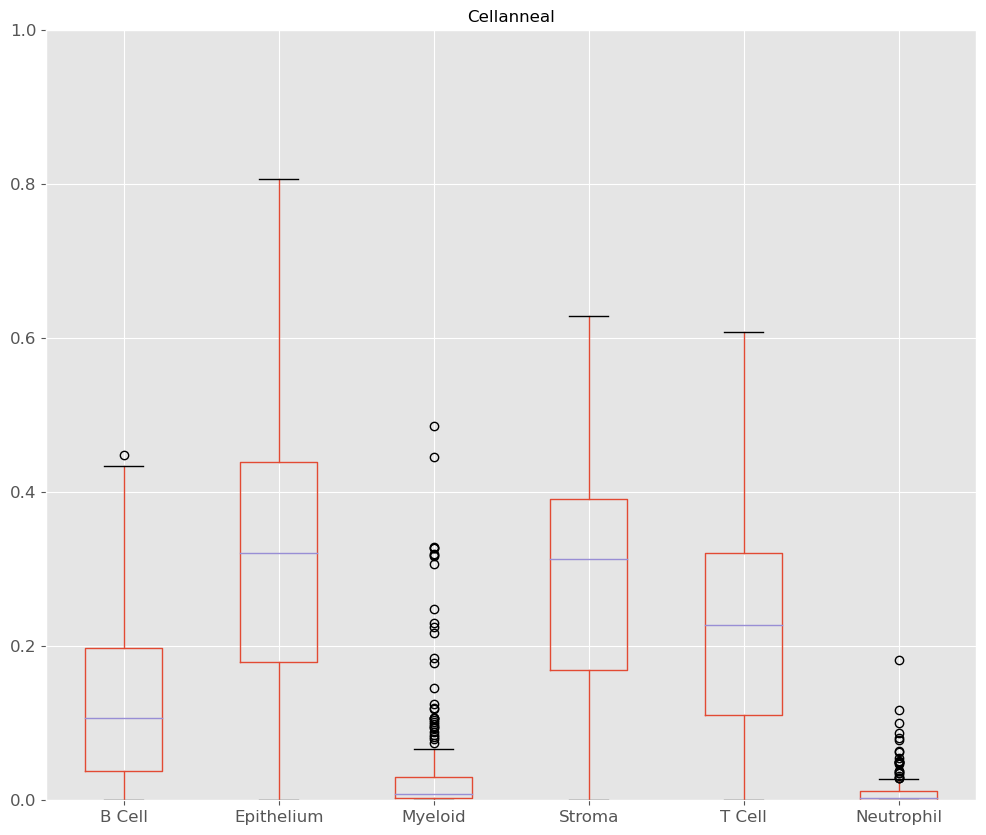

In [79]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.433\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.926\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.481\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.843\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.902\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

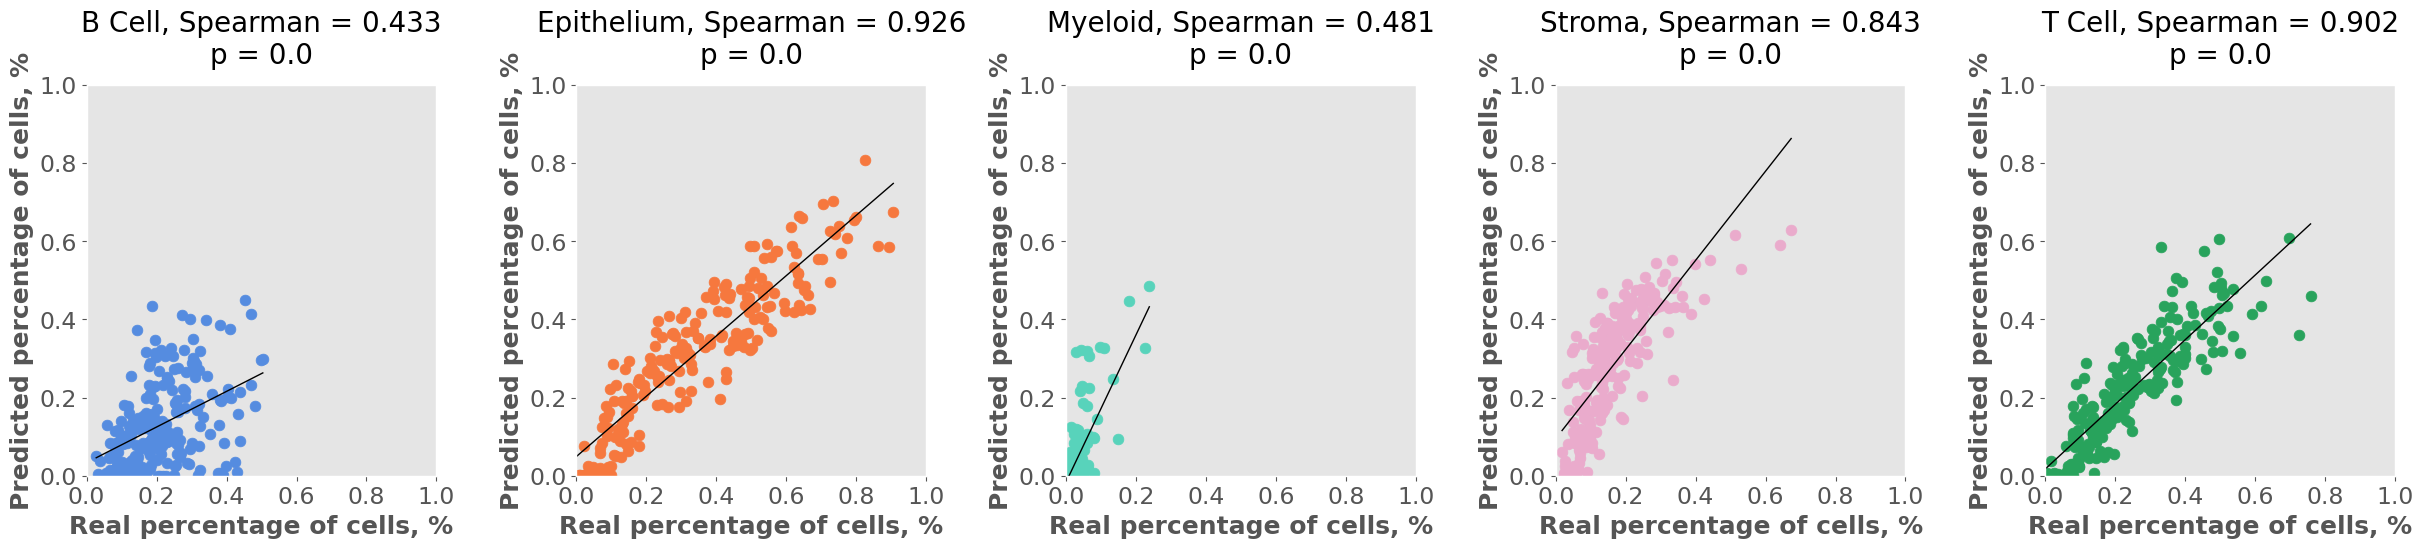

In [80]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

# 40 genes

In [81]:
log = {A:N for (A,N) in [x for x in multiply.items()][:40]}

In [82]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

40


In [83]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top40.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top40.csv",index_col=0)

In [84]:
cellanneal_atap.describe()

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil,rho_Spearman,rho_Pearson
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.128985,0.286237,0.039462,0.326954,0.203379,0.014983,0.842135,0.705870
std,0.106754,0.175926,0.062537,0.122267,0.115898,0.047504,0.078724,0.089474
min,0.000114,0.000018,0.000042,0.010347,0.000056,0.000004,0.613165,0.452175
25%,0.038030,0.156666,0.002731,0.254092,0.119715,0.000573,0.780956,0.640114
50%,0.098194,0.294272,0.010726,0.345430,0.199177,0.001587,0.863161,0.729452
75%,0.208872,0.416867,0.045124,0.406414,0.273231,0.005777,0.904959,0.770500
max,0.436050,0.715661,0.297098,0.697792,0.497952,0.341138,0.950508,0.844436


(0.0, 1.0)

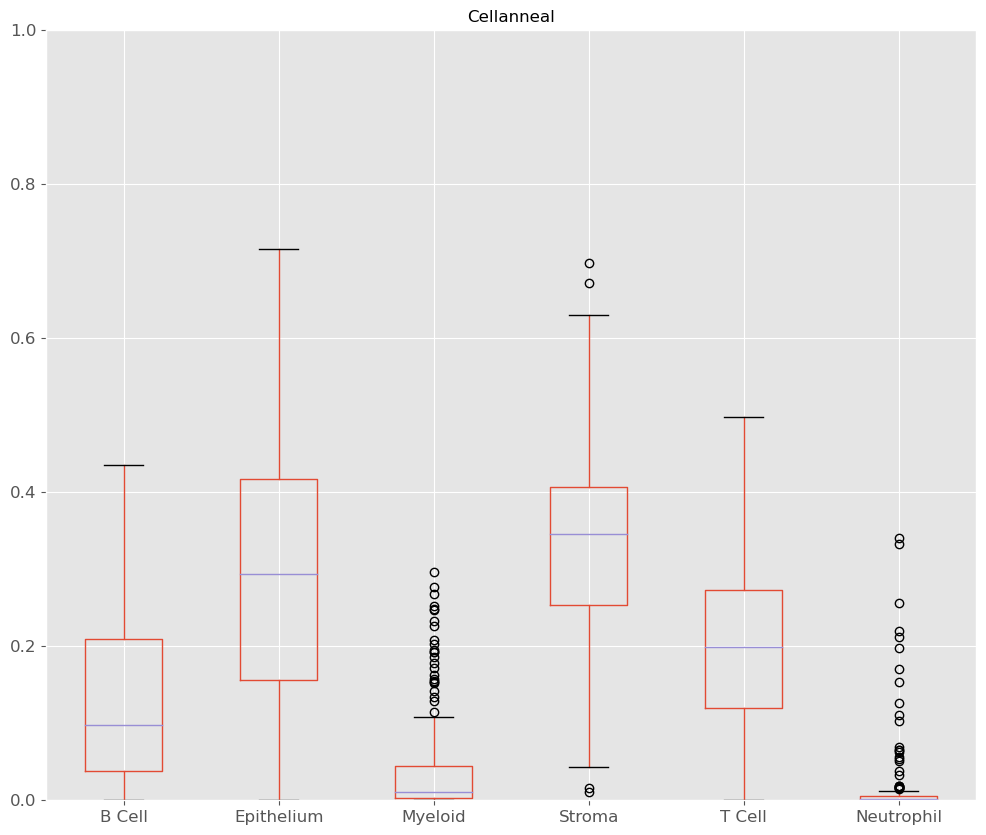

In [85]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.472\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.925\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.607\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.886\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.843\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

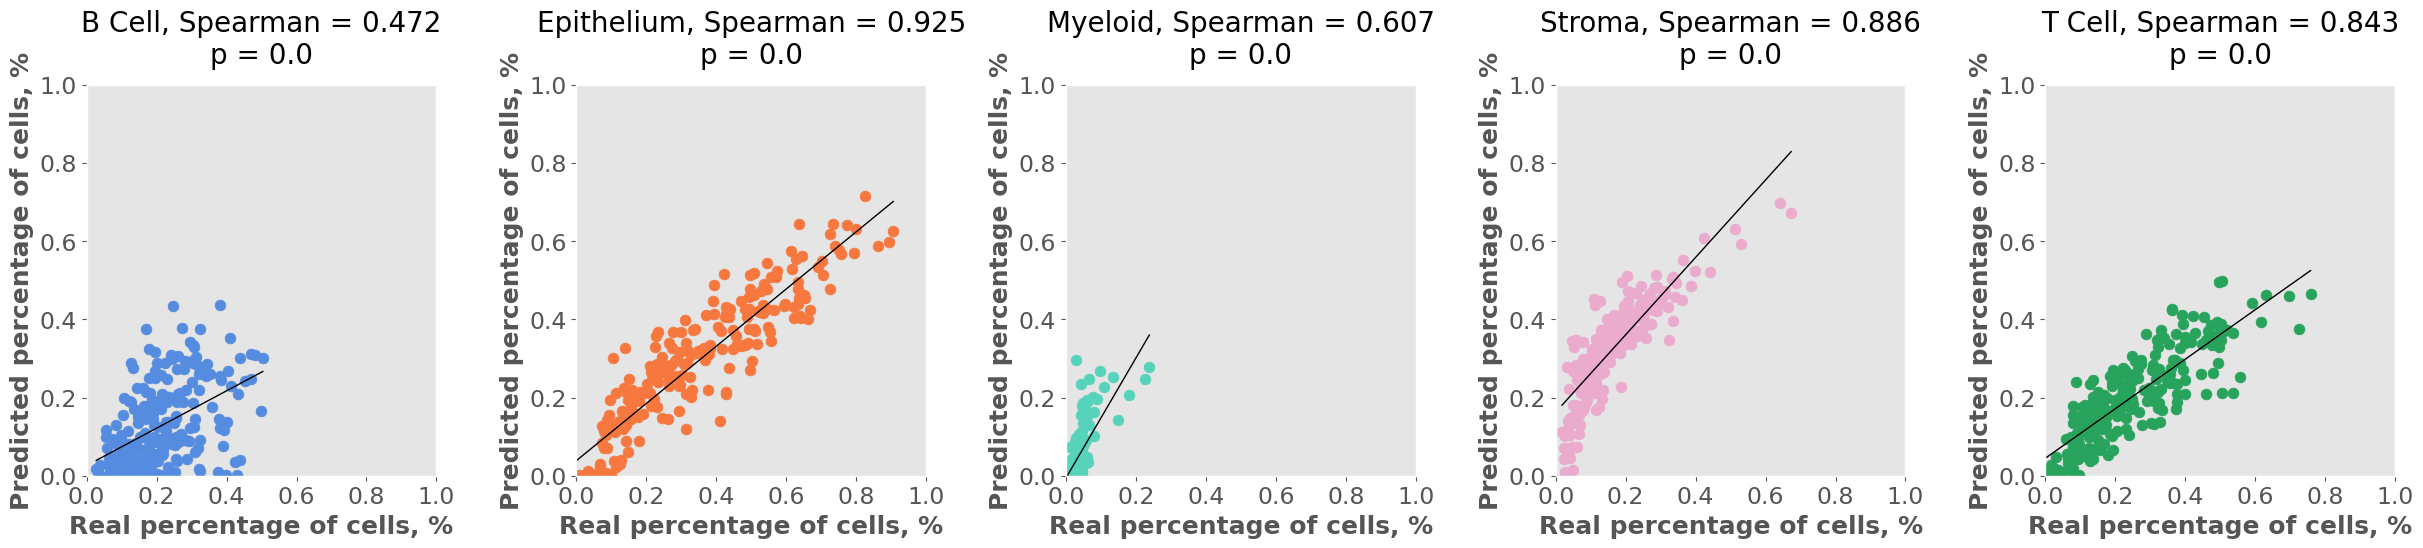

In [86]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

# 20 genes

In [87]:
log = {A:N for (A,N) in [x for x in multiply.items()][:20]}

In [88]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

20


In [89]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top20.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top20.csv",index_col=0)
    pass

(0.0, 1.0)

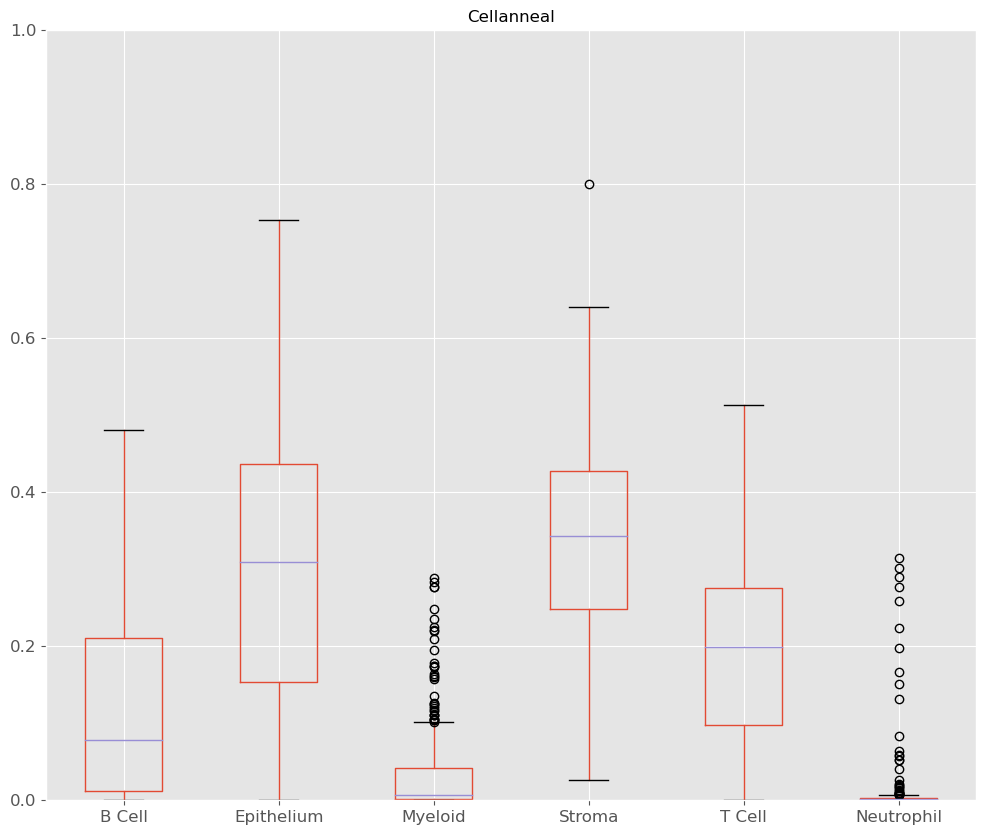

In [90]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.455\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.916\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.678\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.851\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.843\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

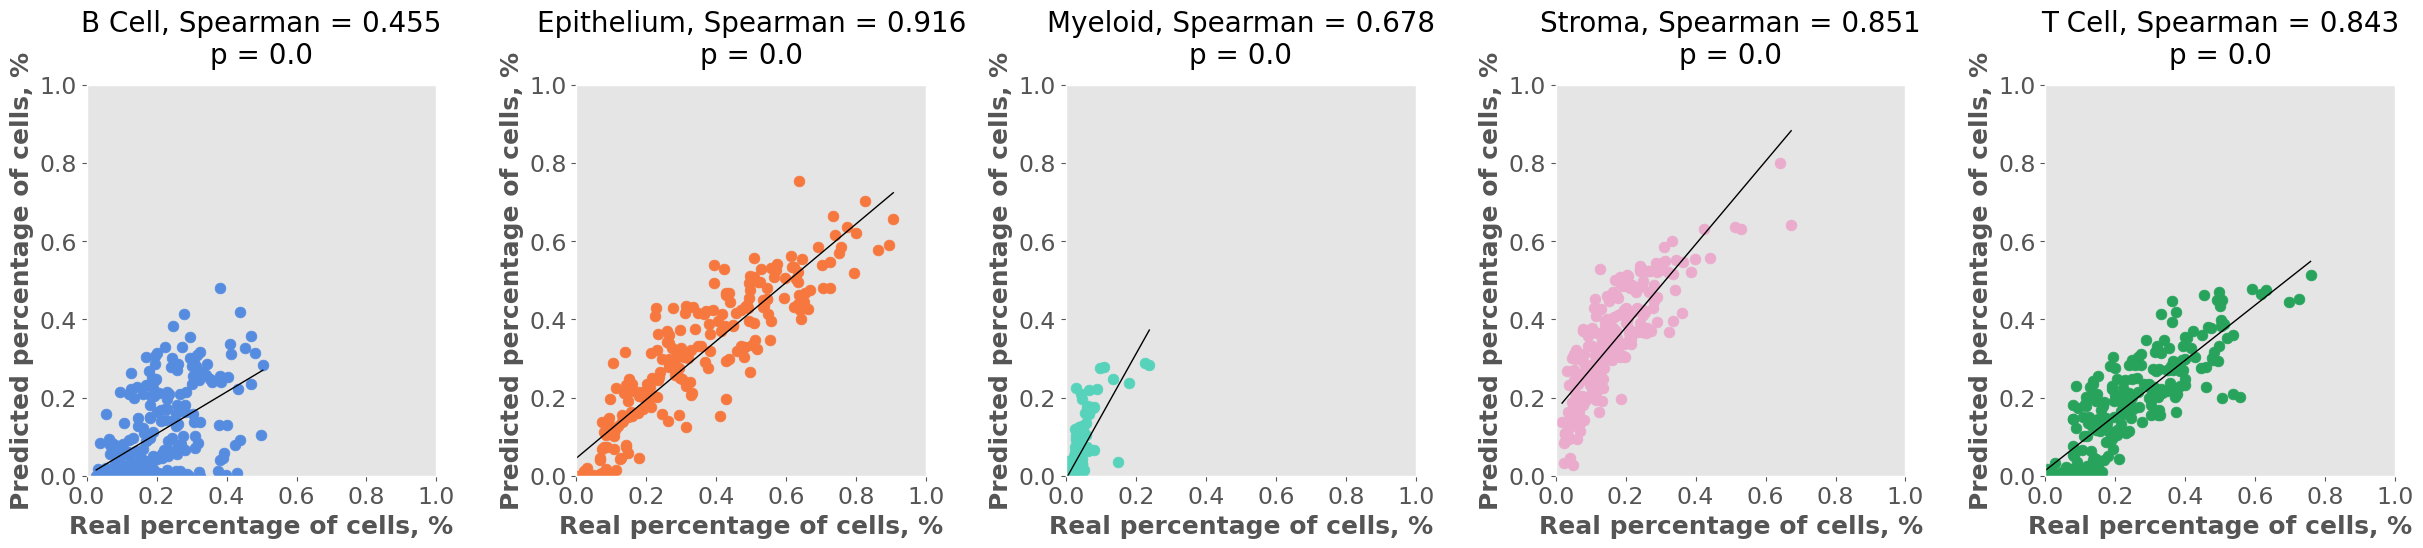

In [91]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

# 15 genes

In [92]:
log = {A:N for (A,N) in [x for x in multiply.items()][:15]}

In [93]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

15


In [94]:
signature.to_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/neutrophil_compartment_ref_2.csv")

In [95]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top15.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top15.csv",index_col=0)
    pass

(0.0, 1.0)

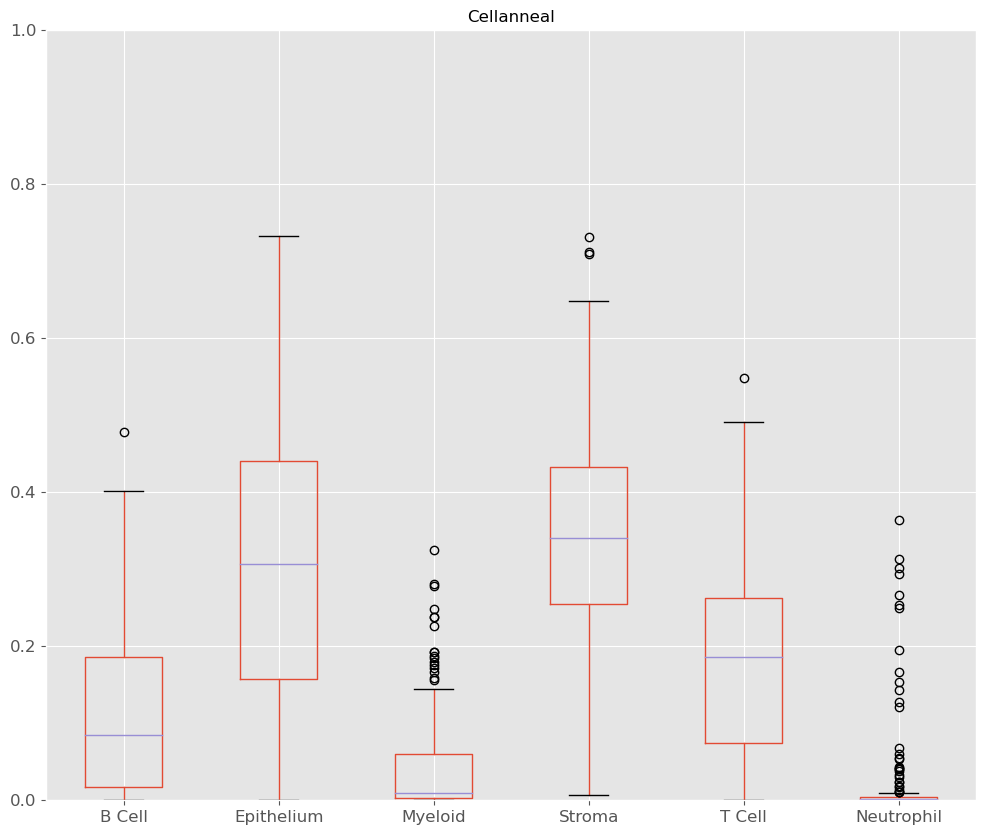

In [96]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

In [97]:
temp = cellanneal_atap[cellanneal_atap['Neutrophil'] > 0.1] 
temp

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil,rho_Spearman,rho_Pearson
CID003377-1,0.059189,0.239267,0.192563,0.151822,0.090779,0.266381,0.661551,0.413851
CID003386-1,0.000501,0.000015,0.226906,0.269500,0.208979,0.294100,0.475521,0.460731
CID003667-1,0.003490,0.000311,0.139020,0.425261,0.288748,0.143169,0.690066,0.616637
CID003669-1,0.056575,0.000072,0.138491,0.293356,0.147689,0.363818,0.633418,0.546955
CID003670-1,0.139879,0.000396,0.064774,0.360723,0.238436,0.195791,0.623581,0.531206
CID003671-1,0.011610,0.000171,0.248378,0.336059,0.276604,0.127178,0.665618,0.488839
CID004697-1,0.223963,0.091381,0.031795,0.285841,0.201060,0.165959,0.734508,0.549166
CID005708-1,0.101706,0.001707,0.167232,0.292312,0.123346,0.313697,0.639349,0.532004
CID005757-1,0.051932,0.068020,0.281193,0.006429,0.290476,0.301949,0.654469,0.513065
CID005764-1,0.105501,0.000261,0.184502,0.260630,0.195688,0.253418,0.772199,0.710509


In [98]:
l = temp.index.to_list()
l

['CID003377-1',
 'CID003386-1',
 'CID003667-1',
 'CID003669-1',
 'CID003670-1',
 'CID003671-1',
 'CID004697-1',
 'CID005708-1',
 'CID005757-1',
 'CID005764-1',
 'CID006571-1',
 'CID006581-1',
 'CID006582-1']

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.449\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.902\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.684\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.844\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.849\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

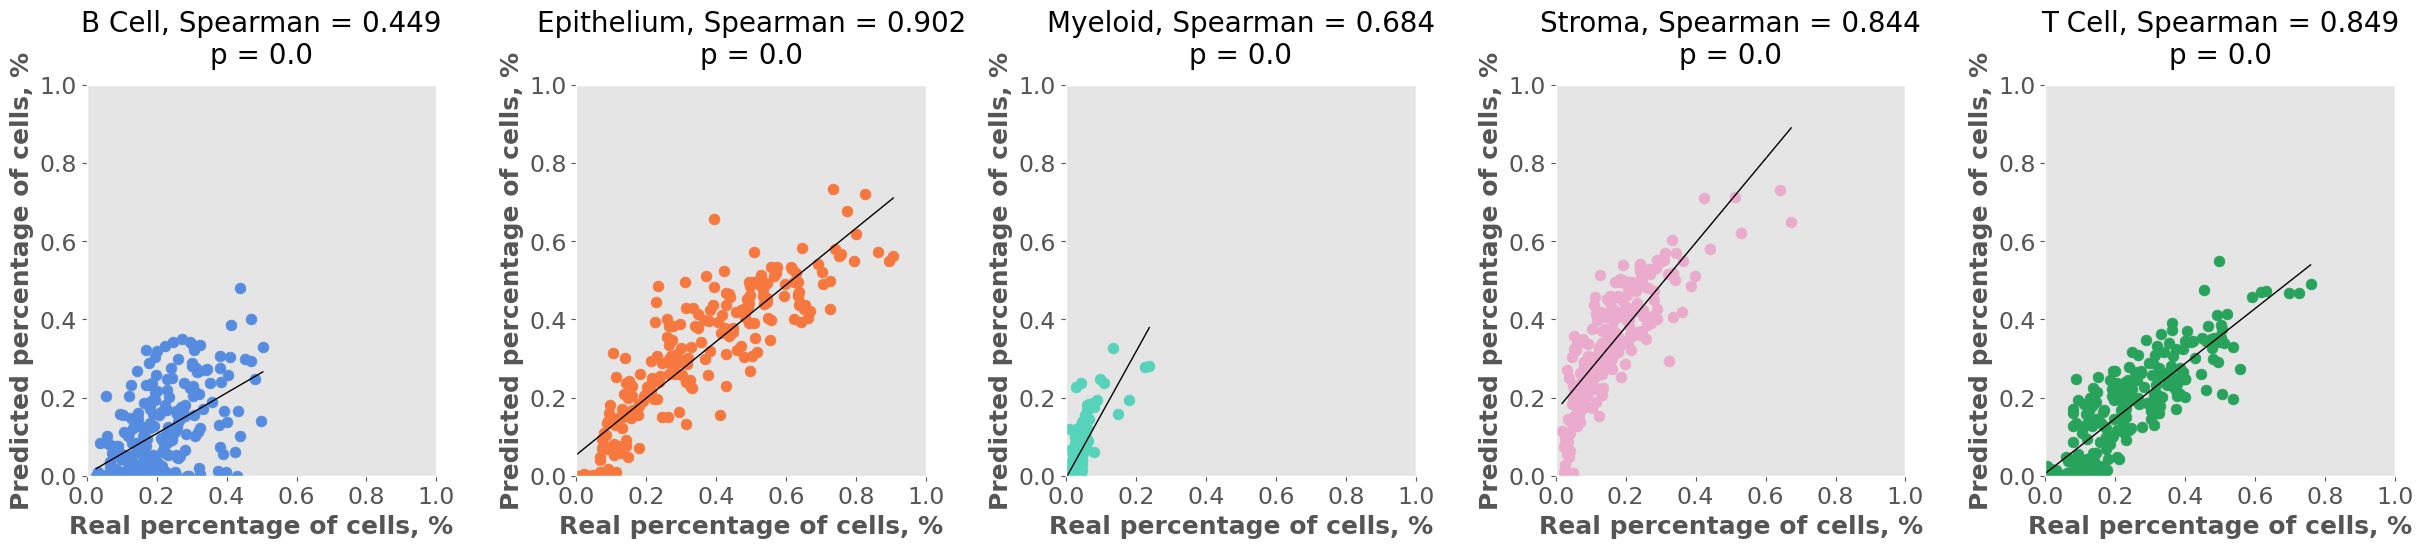

In [ ]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

# 10 genes

In [ ]:
log = {A:N for (A,N) in [x for x in multiply.items()][:10]}

In [ ]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv", index_col=0)
df['logfold']= df.index.map(log)
# df= df.fillna(0)
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df = df.drop("logfold",axis=1)
signature = df

10


In [ ]:
print(df.Neutrophil.astype(bool).sum(axis=0))

10


In [ ]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results7/cellanneal_neutrophil_top10.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results7/cellanneal_neutrophil_top10.csv",index_col=0)
    pass

(0.0, 1.0)

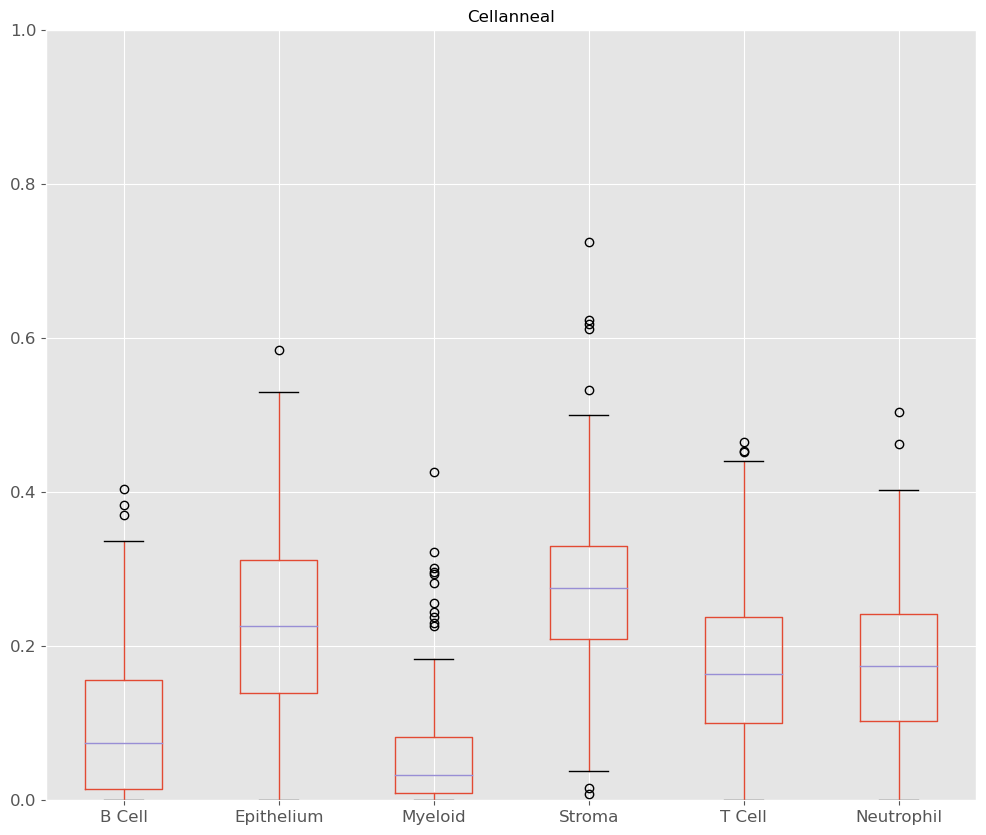

In [ ]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.468\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.896\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.606\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.782\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.868\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

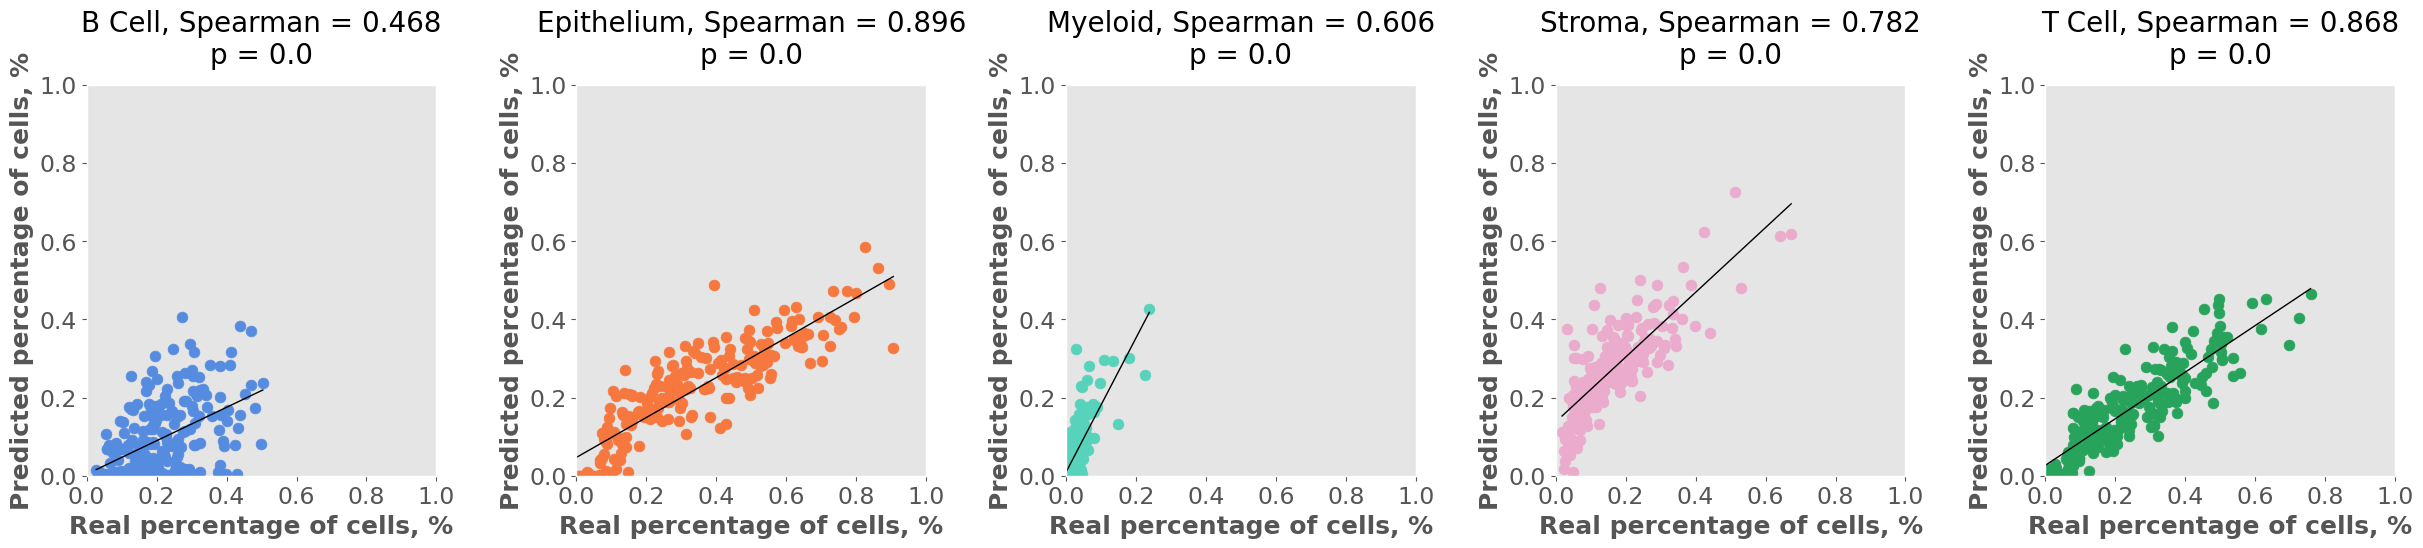

In [ ]:
plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

# added final genes

In [ ]:
logfold = pd.read_csv("../data/differential_expression_results_sorted_MNPs_vs_neutrophs.csv.gz",compression="gzip")
logfold

,gene_id,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000163464,CXCR1,2714.440255,-10.611624,0.945826,-11.219430,3.273740e-29,8.575340e-26
1,ENSG00000163421,PROK2,724.768096,-10.546696,0.702408,-15.015052,5.851570e-51,1.072940e-46
2,ENSG00000230257,NFE4,131.946940,-10.294377,1.016819,-10.124098,4.319440e-24,8.800140e-21
3,ENSG00000140932,CMTM2,695.458442,-10.278832,0.728488,-14.109809,3.304710e-45,2.019840e-41
4,ENSG00000239839,DEFA3,91.052196,-10.144743,1.040649,-9.748474,1.872610e-22,2.641250e-19
...,...,...,...,...,...,...,...,...
18331,ENSG00000245869,AP004609.1,12.446961,7.120187,1.444368,4.929620,8.238950e-07,5.766010e-05
18332,ENSG00000205755,CRLF2,22.341429,7.221118,0.937050,7.706226,1.295930e-14,7.920710e-12
18333,ENSG00000116031,CD207,67.010901,7.735337,1.199967,6.446293,1.146190e-10,3.136800e-08
18334,ENSG00000158488,CD1E,62.718918,8.720672,0.778834,11.197085,4.213710e-29,9.657820e-26


In [ ]:
multiply = dict(zip(logfold.gene_name, logfold.log2FoldChange))

In [ ]:
neutro = {A:N for (A,N) in [x for x in multiply.items()][:20]}
genes = list(neutro.keys())

In [ ]:
values = list(neutro.values())
values = [ (abs(x) - 5.569968698532718) -4.193817 for x in values]

In [ ]:
neutrophil_sig = dict(zip(genes, values))
neutrophil_sig

{'CXCR1': 0.8478379214672813,
 'PROK2': 0.7829099414672811,
 'NFE4': 0.5305916414672822,
 'CMTM2': 0.5150464814672819,
 'DEFA3': 0.38095745146728177,
 'FCGR3B': -0.047239774532718215,
 'TGM3': -0.11970167753271888,
 'NECAB2': -0.37763788053271874,
 'AC073172.1': -0.5186627025327191,
 'IL18RAP': -0.5675812365327175,
 'CXCR2': -1.2498069125327191,
 'KIR2DS4': -1.6054523765327176,
 'PGLYRP1': -1.8417243065327185,
 'CSF2RBP1': -2.067810596532718,
 'PRF1': -2.2394609595327184,
 'LINC00211': -2.3832992105327184,
 'LINC01506': -2.390605829532718,
 'ROPN1L': -2.550300626532718,
 'NLRP6': -2.563278826532718,
 'LINC00664': -2.565398539532718}

In [ ]:
df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments_with_neutrophils.csv", index_col=0)
df['logfold']= df.index.map(multiply2)
df= df.fillna(0)
print(df.logfold.astype(bool).sum(axis=0))
df['Neutrophil'] = df['Myeloid'] + df['logfold']
df = df.drop("logfold",axis=1)
signature = df

102


In [ ]:
temp = df.iloc[:,-1]
temp = temp[temp!=0]
temp = temp.sort_values()
temp

CXCR1      -10.611624
PROK2      -10.546696
NFE4       -10.294377
CMTM2      -10.278832
DEFA3      -10.144743
              ...    
HLA-DPB1    15.447853
HLA-DRA     15.657335
CCL22       16.329279
FCER1A      16.333125
CD1E        16.492995
Name: Neutrophil, Length: 522, dtype: float64

In [ ]:
multiply = dict(zip(temp.index, temp.values))

In [ ]:
def neutrophiller(n):
    log = {A:N for (A,N) in [x for x in multiply2.items()][:n]}
    df = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/logcpm_marker_gene_expression.by_compartments.csv",index_col=0)
    df['logfold']= df.index.map(log)
    # df= df.fillna(0)
    df['Neutrophil'] = df['Myeloid'] + df['logfold']
    df= df.fillna(0)
    df = df.drop("logfold",axis=1)
    df['Neutrophil'].iloc[-20:] = 0
    df['Neutrophil2']= df.index.map(neutrophil_sig)
    df = df.fillna(0)
    df['Neutrophil'] = (df['Neutrophil']+df['Neutrophil2'])
    df = df.drop("Neutrophil2",axis=1)
    display(df)
    signature = df

    temp = signature.loc[signature['Neutrophil'] != 0] 
    display(temp)

    # Cellanneal

    if not train_flag:
        cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
        cellanneal_atap.to_csv("../data/results8/cellanneal_neutrophil_top"+str(n)+".csv")
    else:
        cellanneal_atap = pd.read_csv("../data/results8/cellanneal_neutrophil_top"+str(n)+".csv",index_col=0)
        pass

    # box plot 
    temp = cellanneal_atap.iloc[:,:6]
    temp.boxplot()
    plt.title("Cellanneal")
    plt.ylim([0,1.0])

    # scatter plot
    plot_object.plot_cell(cellanneal_atap.T, atap_true_general.T, pallete=cells_p)

    # # describe dataframe
    # temp.describe()


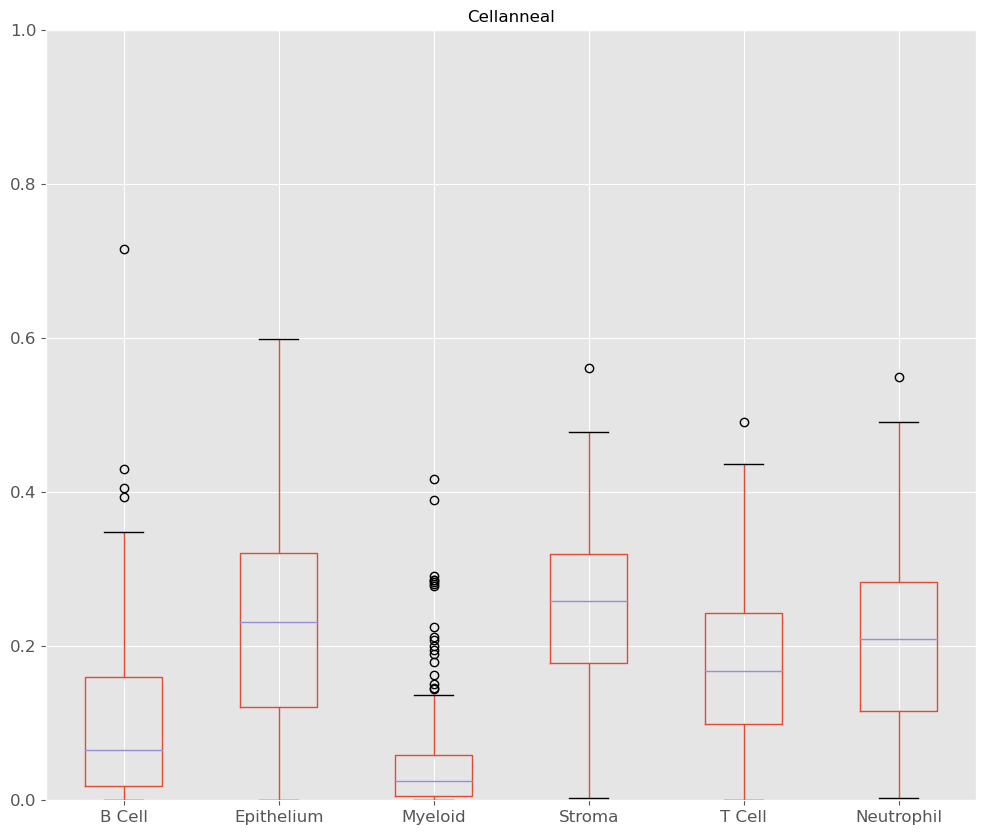

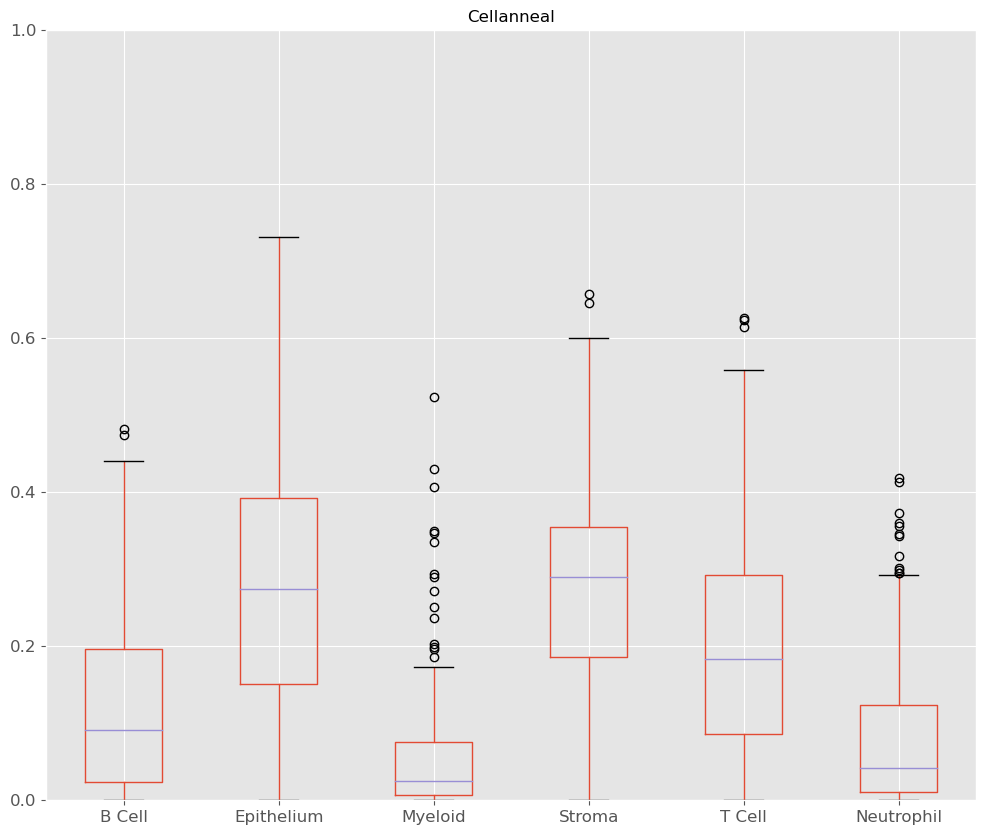

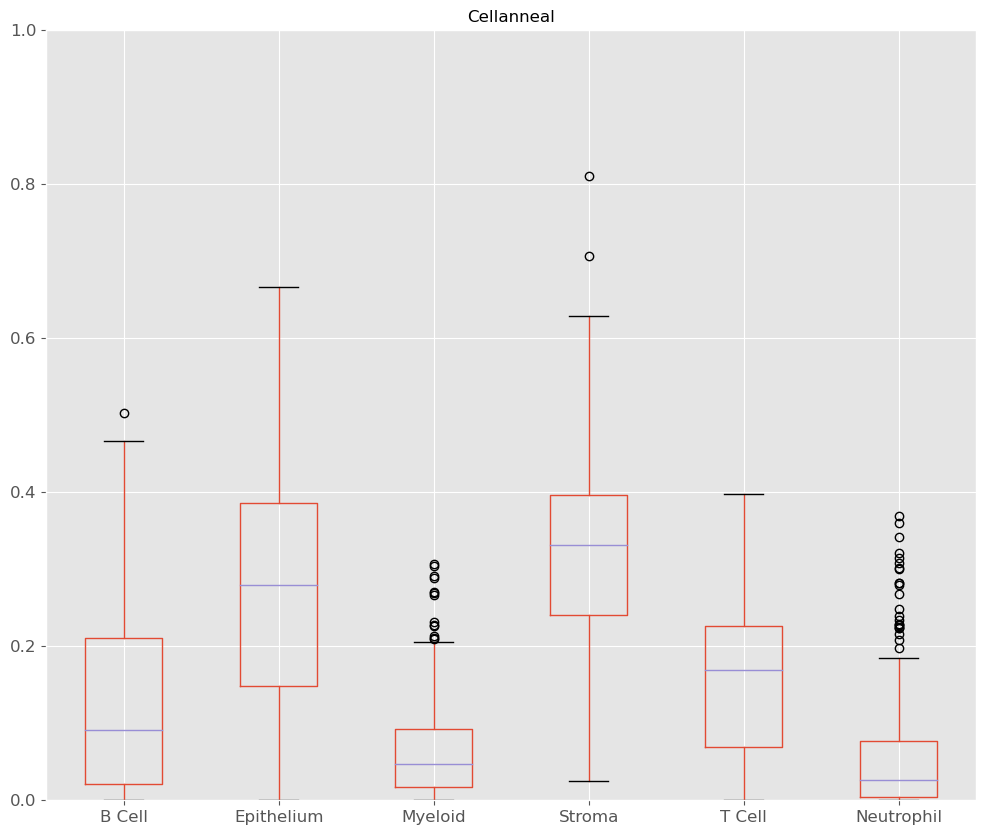

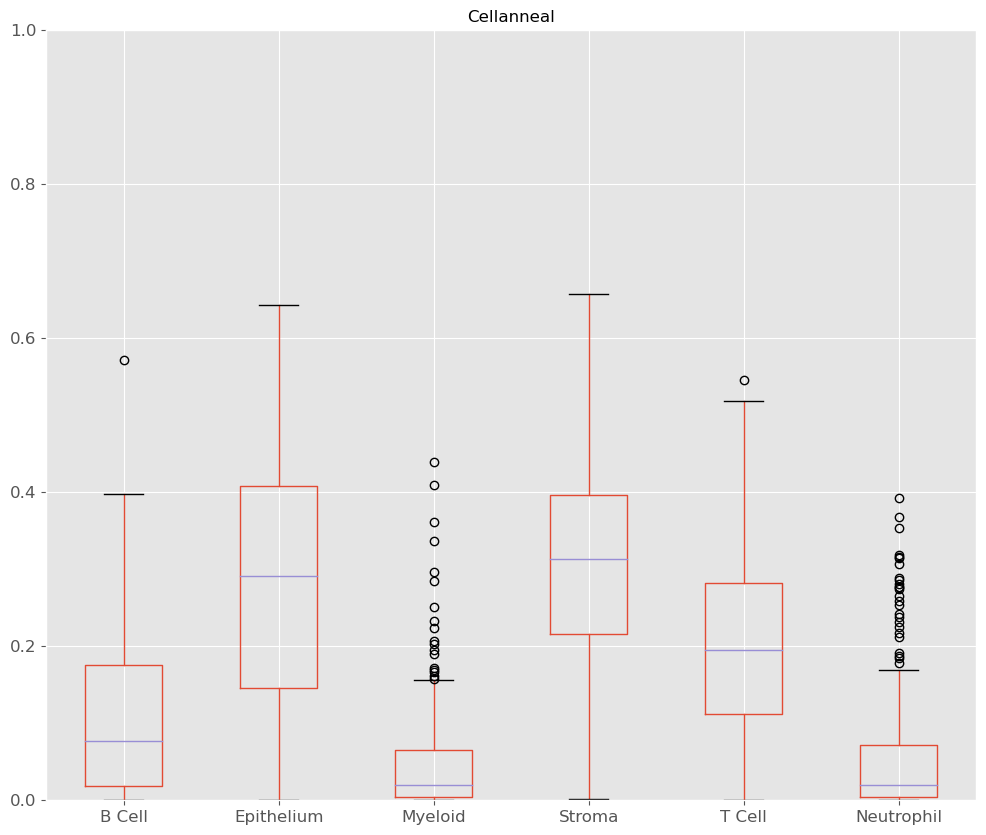

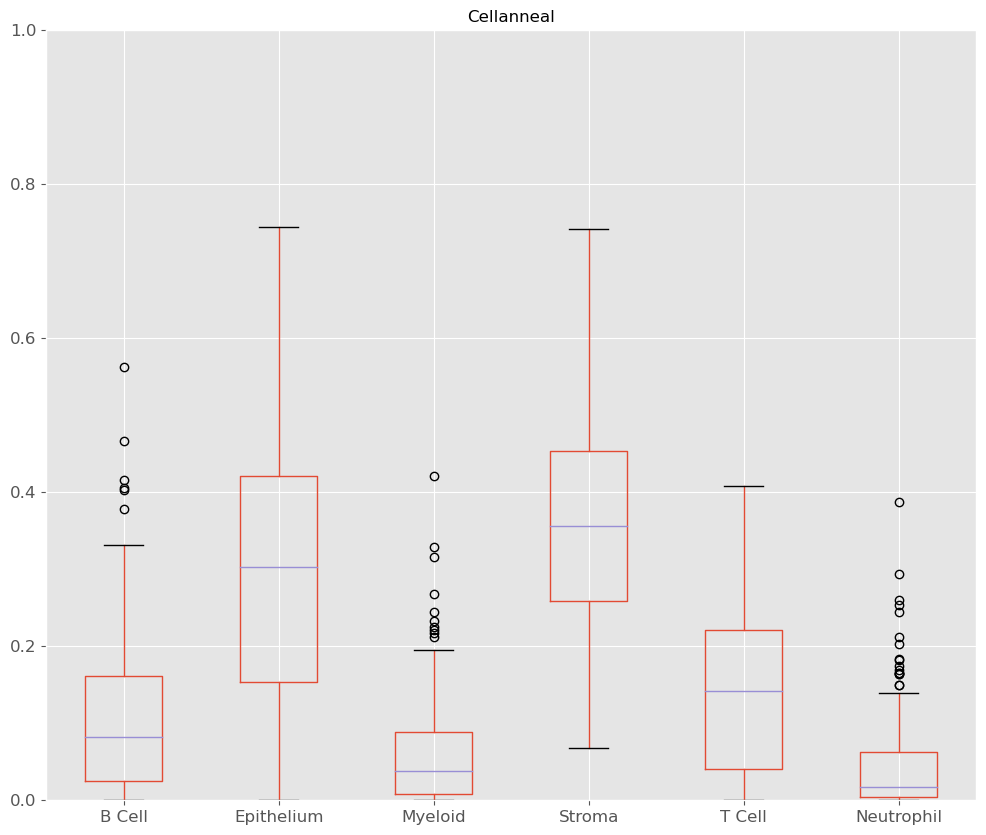

In [ ]:
df = pd.read_csv("../data/results8/cellanneal_neutrophil_top20.csv",index_col=0)
temp = df.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()
df = pd.read_csv("../data/results8/cellanneal_neutrophil_top30.csv",index_col=0)
temp = df.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()
df = pd.read_csv("../data/results8/cellanneal_neutrophil_top35.csv",index_col=0)
temp = df.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()
df = pd.read_csv("../data/results8/cellanneal_neutrophil_top40.csv",index_col=0)
temp = df.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()
df = pd.read_csv("../data/results8/cellanneal_neutrophil_top80.csv",index_col=0)
temp = df.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])
plt.show()

In [ ]:
signature = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/20230523_logcp_marker_gene_with_neutrophil.csv",index_col=0)
signature

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil
IGHV3-13,4.980656,1.333944,1.864680,1.532558,1.954512,0.000000
CEACAM7,4.380691,9.786583,3.619825,2.426693,3.630942,0.000000
HNF4A,3.485610,8.545540,2.476539,1.870433,2.601221,0.000000
IGLV10-54,6.287763,1.377721,2.887041,2.401113,3.306973,0.000000
RAB25,4.972021,9.833682,3.448122,2.608023,4.056638,0.000000
...,...,...,...,...,...,...
SLC7A4,0.000000,0.000000,0.000000,0.000000,0.000000,18.393659
TGM3,0.000000,0.000000,0.000000,0.000000,0.000000,21.370079
TNFRSF10C,0.000000,0.000000,0.000000,0.000000,0.000000,18.411147
TTPA,0.000000,0.000000,0.000000,0.000000,0.000000,16.376769


In [ ]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results8/cellanneal_neutrophil.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results8/cellanneal_neutrophil.csv",index_col=0)
    pass

(0.0, 1.0)

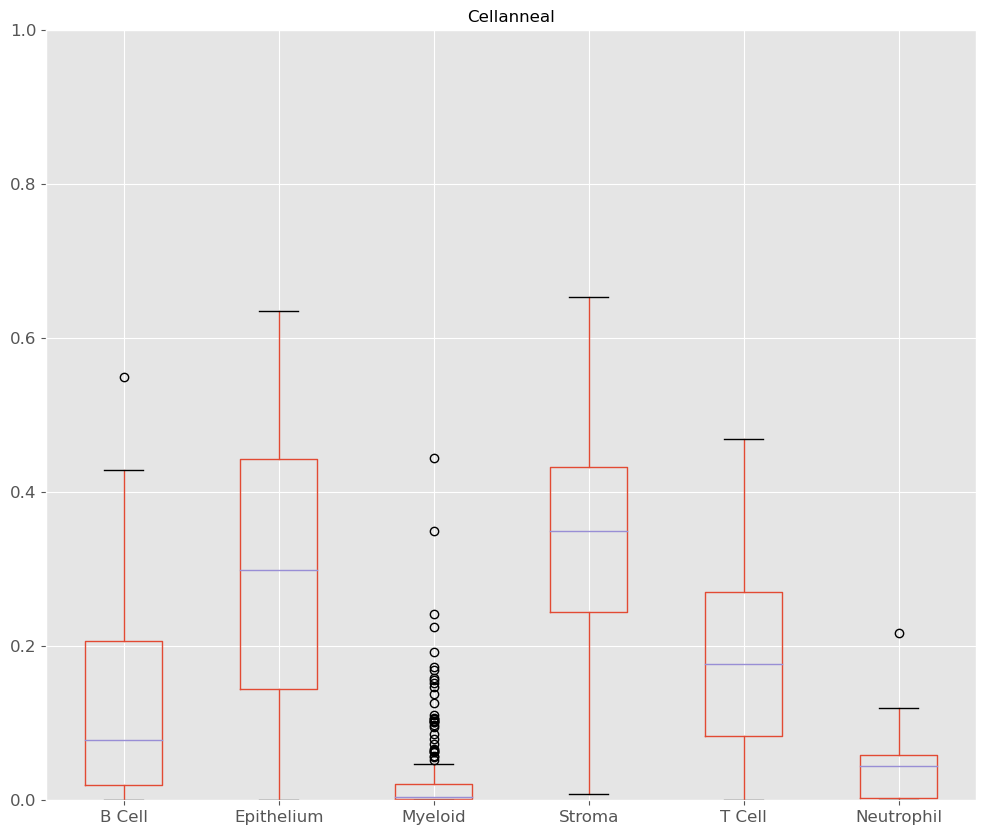

In [ ]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

In [ ]:
for i in signature.columns:
    signature[i] = (signature[i] - signature[i].min()) / (signature[i].max()-signature[i].min())
    signature[i] = signature[i]/signature[i].sum()
signature

,B Cell,Epithelium,Myeloid,Stroma,T Cell,Neutrophil
IGHV3-13,0.001794,0.000669,0.000714,0.000705,0.000836,0.000000
CEACAM7,0.001578,0.004910,0.001385,0.001116,0.001552,0.000000
HNF4A,0.001256,0.004288,0.000948,0.000861,0.001112,0.000000
IGLV10-54,0.002265,0.000691,0.001105,0.001105,0.001414,0.000000
RAB25,0.001791,0.004934,0.001320,0.001200,0.001735,0.000000
...,...,...,...,...,...,...
SLC7A4,0.000000,0.000000,0.000000,0.000000,0.000000,0.009213
TGM3,0.000000,0.000000,0.000000,0.000000,0.000000,0.010704
TNFRSF10C,0.000000,0.000000,0.000000,0.000000,0.000000,0.009222
TTPA,0.000000,0.000000,0.000000,0.000000,0.000000,0.008203


In [ ]:
signature.sum(axis = 0, skipna = True)

B Cell        1.0
Epithelium    1.0
Myeloid       1.0
Stroma        1.0
T Cell        1.0
Neutrophil    1.0
dtype: float64

In [ ]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(signature, atap_bulk)
    cellanneal_atap.to_csv("../data/results8/cellanneal_neutrophil2.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results8/cellanneal_neutrophil2.csv",index_col=0)
    pass

(0.0, 1.0)

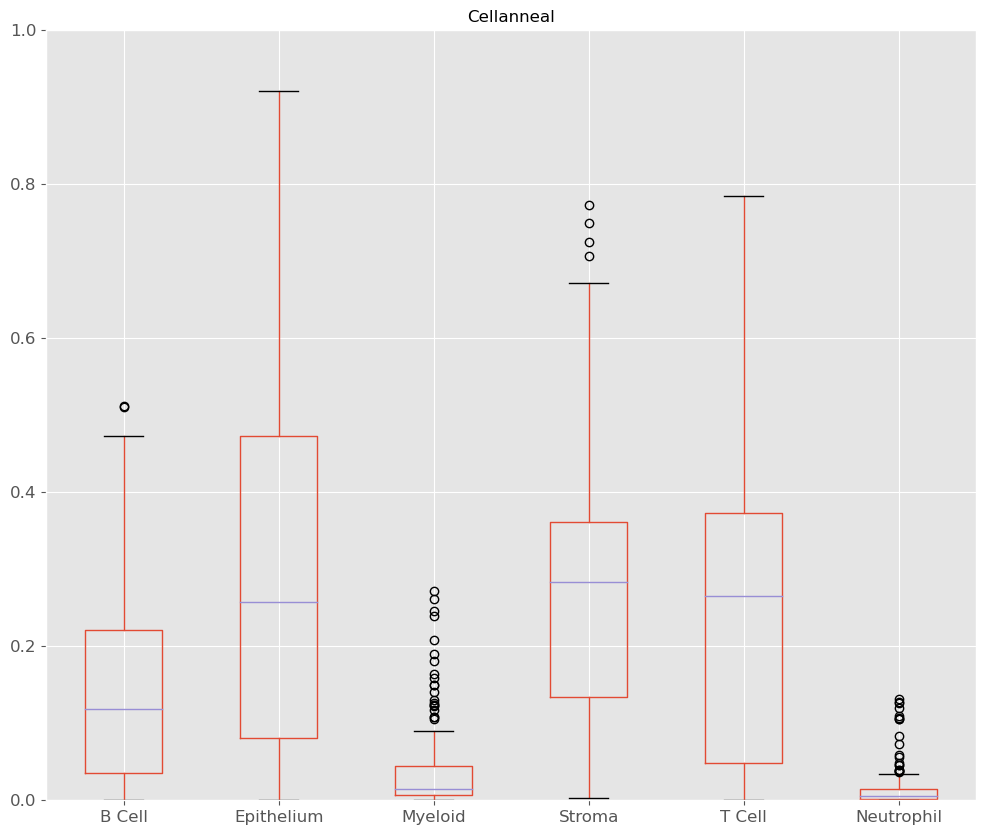

In [ ]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

# try top 20, 40

In [ ]:
signature = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/20230523_logcp_marker_gene_with_neutrophil.csv",index_col=0)

In [ ]:
keep_genes = pd.melt(signature.reset_index(), id_vars='index').sort_values('value', ascending=False).groupby('variable').head(20).pivot(index='index', columns='variable').index
ref = signature.loc[keep_genes]

In [ ]:
ref.to_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/neutrophil_compartment_ref.csv")

In [ ]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results8/cellanneal_neutrophil2.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results8/cellanneal_neutrophil2.csv",index_col=0)
    pass

(0.0, 1.0)

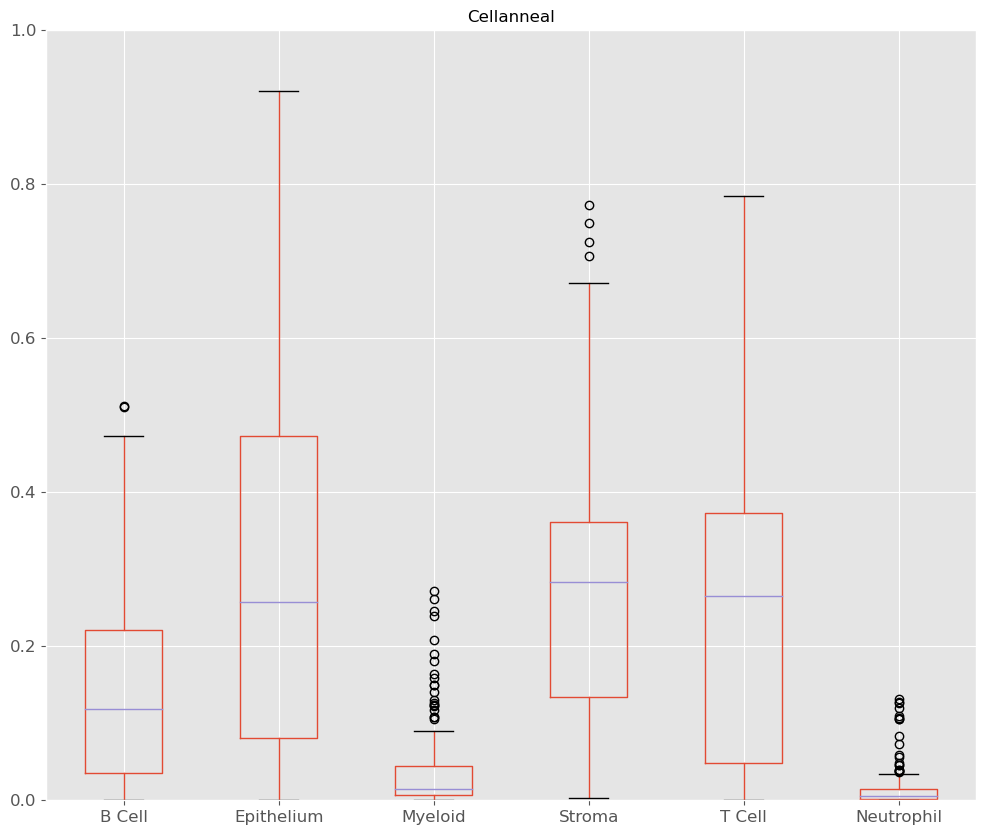

In [ ]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

In [ ]:
l = ['S100A4', 'SRGN', 'IFITM2', 'S100A8', 'S100A9', 'HLA-DRA', 'HLA-DPB1']
for i in l:
    ref = ref.drop(i)


In [ ]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results8/cellanneal_neutrophil3.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results8/cellanneal_neutrophil3.csv",index_col=0)
    pass

(0.0, 1.0)

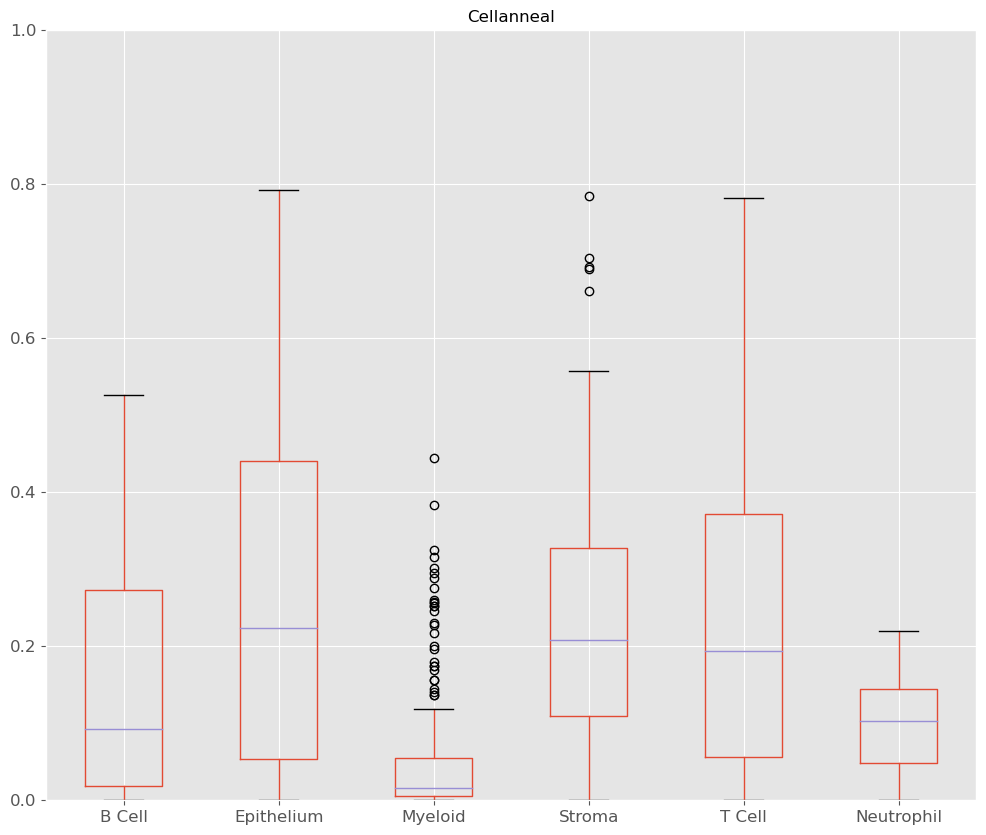

In [ ]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

In [ ]:
keep_genes = pd.melt(signature.reset_index(), id_vars='index').sort_values('value', ascending=False).groupby('variable').head(40).pivot(index='index', columns='variable').index
ref = signature.loc[keep_genes]

In [ ]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results8/cellanneal_neutrophil4.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results8/cellanneal_neutrophil4.csv",index_col=0)
    pass

(0.0, 1.0)

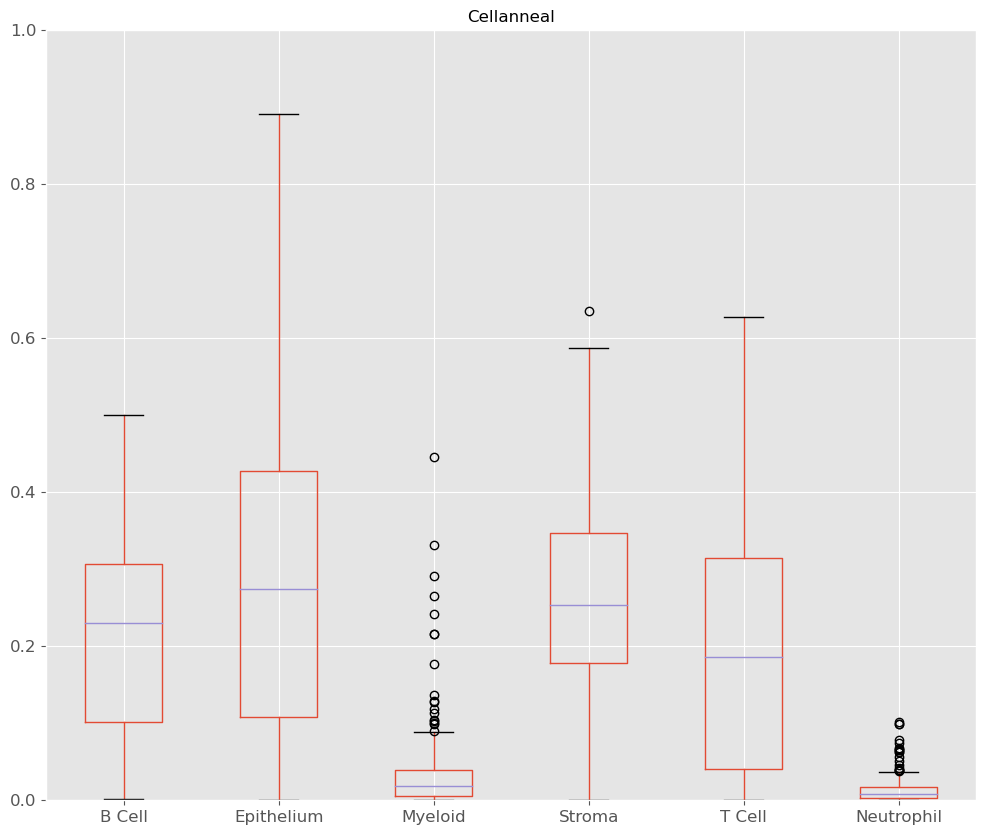

In [ ]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

array([<AxesSubplot: title={'center': 'B Cell, Spearman = 0.481\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Epithelium, Spearman = 0.948\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Myeloid, Spearman = 0.281\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'Stroma, Spearman = 0.824\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>,
       <AxesSubplot: title={'center': 'T Cell, Spearman = 0.836\np = 0.0'}, xlabel='Real percentage of cells, %', ylabel='Predicted percentage of cells, %'>],
      dtype=object)

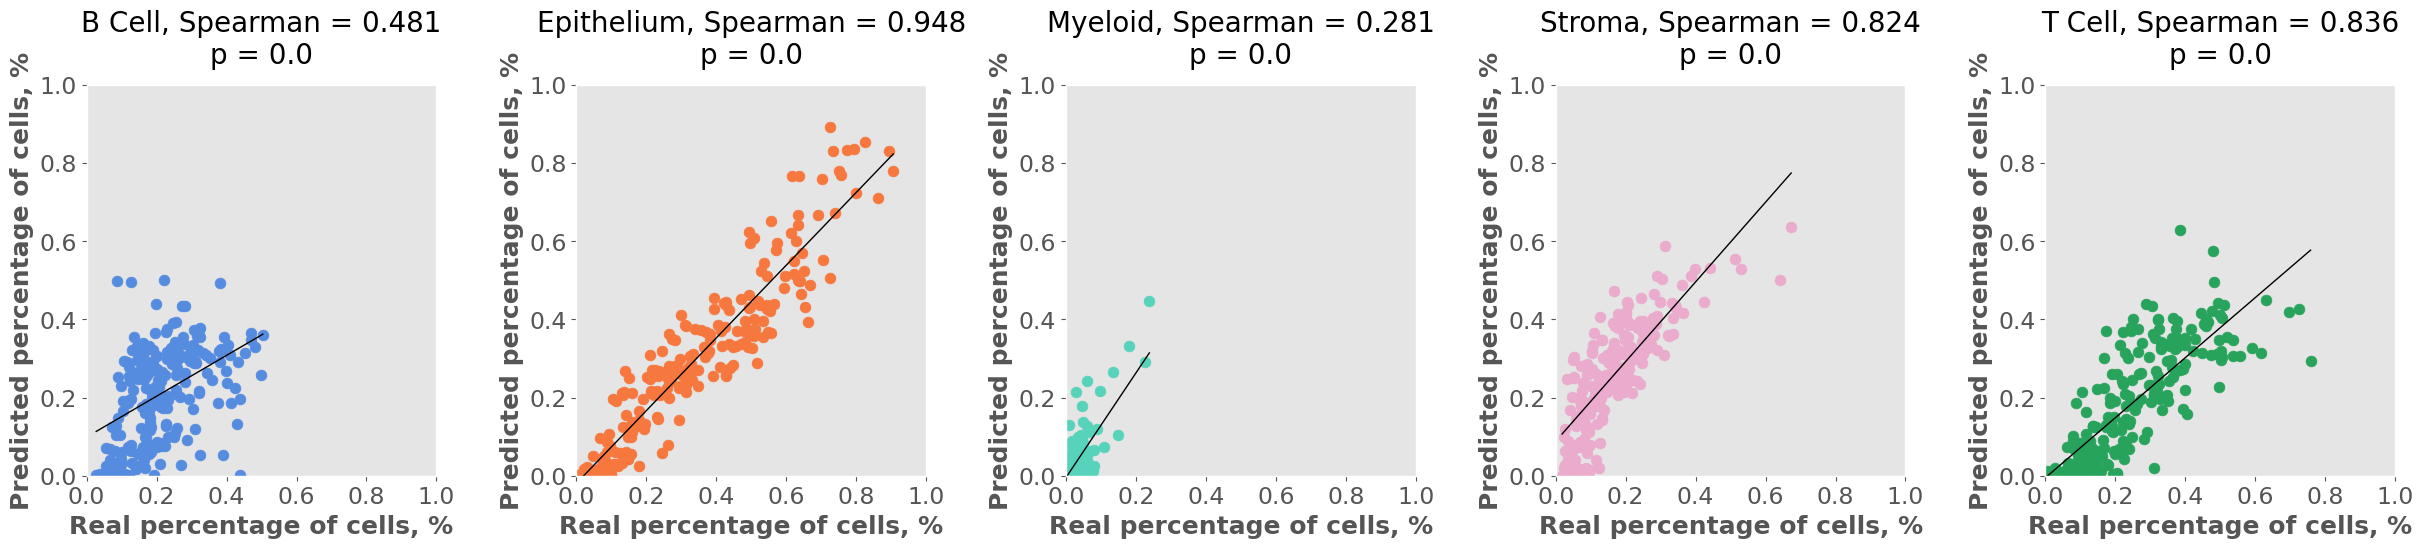

In [ ]:
plot_object.plot_cell(cellanneal_atap.T,atap_true_general.T,pallete=cells_p)

In [100]:
signature = pd.read_csv("../../../../../cbbi-data00/projects/Methods/bulk-deconvolution/20230523_logcp_marker_gene_with_neutrophil.csv",index_col=0)

In [ ]:
keep_genes = pd.melt(signature.reset_index(), id_vars='index').sort_values('value', ascending=False).groupby('variable').head(15).pivot(index='index', columns='variable').index
ref = signature.loc[keep_genes]

In [ ]:
if train_flag:
    cellanneal_atap = deconvolution_object.deconvolution(ref, atap_bulk)
    cellanneal_atap.to_csv("../data/results8/cellanneal_neutrophil_15.csv")
else:
    cellanneal_atap = pd.read_csv("../data/results8/cellanneal_neutrophil_15.csv",index_col=0)
    pass

34 highly variable genes identified in cell type
        reference.
	31 of these are within thresholds for sample CID003352-2
	30 of these are within thresholds for sample CID003353-1
	30 of these are within thresholds for sample CID003354-1
	31 of these are within thresholds for sample CID003355-1
	31 of these are within thresholds for sample CID003356-1
	31 of these are within thresholds for sample CID003357-1
	31 of these are within thresholds for sample CID003358-1
	30 of these are within thresholds for sample CID003359-1
	31 of these are within thresholds for sample CID003360-1
	31 of these are within thresholds for sample CID003361-1
	30 of these are within thresholds for sample CID003362-1
	31 of these are within thresholds for sample CID003363-1
	31 of these are within thresholds for sample CID003364-1
	31 of these are within thresholds for sample CID003365-1
	31 of these are within thresholds for sample CID003366-1
	31 of these are within thresholds for sample CID003367-2
	31 

(0.0, 1.0)

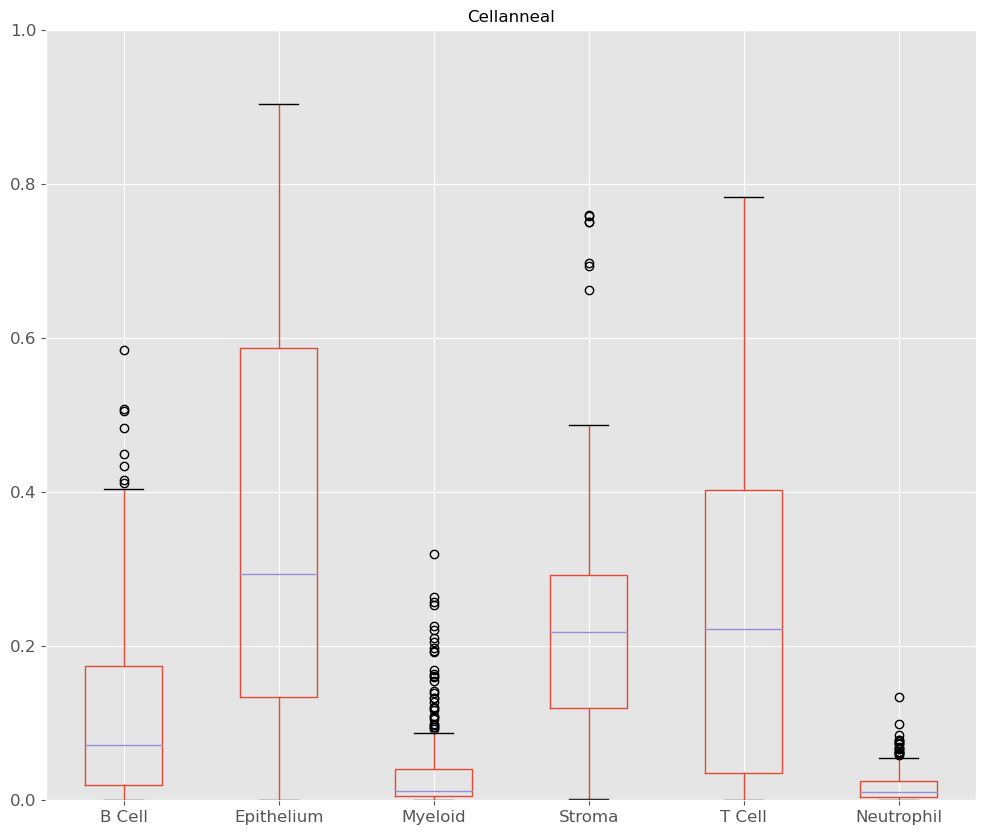

In [ ]:
temp = cellanneal_atap.iloc[:,:6]
temp.boxplot()
plt.title("Cellanneal")
plt.ylim([0,1.0])

In [101]:
keep_genes = pd.melt(signature.reset_index(), id_vars='index').sort_values('value', ascending=False).groupby('variable').head(45).pivot(index='index', columns='variable').index
ref = signature.loc[keep_genes]

# Get the indices of the top N nonzero entries of each compartment column
l =[]
for i in ref.columns:
    temp = ref
    temp = temp.replace(0,np.nan)
    temp = temp[i]
    temp=temp.dropna()
    temp = temp.sort_values(ascending=False)
    lx = temp.index.to_list()
    lx = lx[:45]
    l.append(lx)

# find all the unique genes by taking the intersection of all combinations of compartments
genes = []
for i in range(len(l)):
    for j in range(len(l)):
        if i == j:
            continue
        print(i,j)
        l1 = set(l[i]).intersection(set(l[j]))
        print(l1)
        genes.append(list(l1))

genes = [item for sublist in genes for item in sublist]
genes = list(set(genes))
print("Dropping {} Genes".format(len(genes)))

0 1
{'IGHA1', 'BTG1'}
0 2
{'HERPUD1', 'HLA-DPB1', 'HLA-DRA', 'SRGN', 'S100A4', 'RGCC', 'IGKC', 'IFITM2', 'DUSP2', 'IGHA1', 'CD52', 'GPR183', 'CD69', 'PTPRC', 'BTG1'}
0 3
{'HERPUD1', 'IGHA2', 'HLA-DRA', 'SRGN', 'S100A4', 'RGCC', 'IFITM2', 'IGKC', 'IGHA1', 'BTG1'}
0 4
{'SEPT6', 'S100A4', 'IGHA1', 'GPR183', 'CD52', 'HERPUD1', 'CREM', 'CXCR4', 'RGCC', 'LTB', 'IGLC3', 'PTPRC', 'ZNF331', 'ACAP1', 'SRGN', 'IFITM2', 'IGKC', 'DUSP2', 'IGHA2', 'IGHM', 'CD69', 'BTG1'}
0 5
set()
1 0
{'IGHA1', 'BTG1'}
1 2
{'IGHA1', 'BTG1'}
1 3
{'IGHA1', 'IL32', 'BTG1'}
1 4
{'IGHA1', 'IL32', 'BTG1'}
1 5
set()
2 0
{'HERPUD1', 'HLA-DPB1', 'HLA-DRA', 'SRGN', 'S100A4', 'RGCC', 'IGKC', 'IFITM2', 'DUSP2', 'IGHA1', 'CD52', 'GPR183', 'CD69', 'PTPRC', 'BTG1'}
2 1
{'IGHA1', 'BTG1'}
2 3
{'HERPUD1', 'ANXA1', 'HLA-DRA', 'SRGN', 'S100A4', 'RGCC', 'IFITM2', 'IGKC', 'IGHA1', 'BTG1'}
2 4
{'HERPUD1', 'ANXA1', 'SRGN', 'S100A4', 'RGCC', 'IFITM2', 'IGKC', 'TNFAIP3', 'DUSP2', 'IGHA1', 'PTPRC', 'GPR183', 'CD52', 'CCL4', 'CD69', 'HCST', 'B

In [102]:
genes

['SEPT6',
 'HLA-DPB1',
 'HLA-DRA',
 'S100A4',
 'TNFAIP3',
 'IGHA1',
 'CD52',
 'GPR183',
 'HCST',
 'HERPUD1',
 'CREM',
 'ANXA1',
 'CXCR4',
 'RGCC',
 'LTB',
 'CCL4',
 'IGLC3',
 'IL32',
 'PTPRC',
 'ZNF331',
 'ACAP1',
 'SRGN',
 'IGKC',
 'IFITM2',
 'DUSP2',
 'IGHA2',
 'IGHM',
 'CD69',
 'BTG1']